In [1]:
import define_transformations_afolu as dta
import define_transformations_circular_economy as dtc
import define_transformations_energy as dte
import define_transformations_ippu as dti
import define_transformations_integrated as dtr

import os, os.path
import numpy as np
import pandas as pd
#from model_attributes import *
import model_attributes as ma
import model_afolu as mafl
import model_ippu as mi
import model_circular_economy as mc
import model_electricity as ml
import model_energy as me
import model_socioeconomic as se
import setup_analysis as sa
import sisepuede_data_api as api
import sisepuede_models as sm
import support_classes as sc
import support_functions as sf
import importlib
import time
import warnings
import matplotlib.pyplot as plt
from typing import Union
import inspect
import ingestion as ing
import logging
from sisepuede_file_structure import *
import transformations_base_afolu as tba
import transformations_base_circular_economy as tbc
import transformations_base_energy as tbe
import transformations_base_general as tbg
import transformations_base_ippu as tbi


importlib.reload(ma)
importlib.reload(sa)
importlib.reload(sf)
importlib.reload(mafl)
importlib.reload(mc)
importlib.reload(mi)
importlib.reload(me)
importlib.reload(se)
importlib.reload(tbc)
importlib.reload(tbe)


import sisepuede as ssp


def _setup_logger(namespace: str, fn_out: Union[str, None] = None) -> None:
    global logger
    
    format_str = "%(asctime)s - %(levelname)s - %(message)s"
    # configure
    if fn_out is not None:
        logging.basicConfig(
            filename = fn_out,
            filemode = "w",
            format = format_str,
            level = logging.DEBUG
        )
    else:
        logging.basicConfig(
            format = format_str,
            level = logging.DEBUG
        )
        
    logger = logging.getLogger(namespace)
    # create console handler and set level to debug
    ch = logging.StreamHandler()
    ch.setLevel(logging.DEBUG)
    # create formatter
    formatter = logging.Formatter(format_str)
    # add formatter to ch
    ch.setFormatter(formatter)
    # add ch to logger
    logger.addHandler(ch)

    return logger

_setup_logger(__name__, os.path.join(os.getcwd(), "log_build_sisepuede_transformations.log"))


/Users/jsyme/Documents/Projects/git_jbus/sisepuede/python/model_attributes.py:2662: UserWarning: Invalid subsector attribute 'key_varreqs_partial'. Valid return type values are:'pycategory_primary', 'abv_subsector', 'sector', 'abv_sector', 'key_varreqs_all'
  warnings.warn(f"Invalid subsector attribute '{return_type}'. Valid return type values are:{valid_rts}")
/Users/jsyme/Documents/Projects/git_jbus/sisepuede/python/model_attributes.py:2419: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for desig, df in df_by_designation:
/Users/jsyme/Documents/Projects/git_jbus/sisepuede/python/model_attributes.py:5357: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this w

MISSIONSEARCHNOTE: As of 2023-10-06, there is a temporary solution implemeted in ModelAttributes.get_variable_to_simplex_group_dictionary() to ensure that transition probability rows are enforced on a simplex.

FIX THIS ASAP TO DERIVE PROPERLY.
MISSIONSEARCHNOTE: As of 2023-10-06, there is a temporary solution implemeted in ModelAttributes.get_variable_to_simplex_group_dictionary() to ensure that transition probability rows are enforced on a simplex.

FIX THIS ASAP TO DERIVE PROPERLY.


/Users/jsyme/Documents/Projects/git_jbus/sisepuede/python/model_attributes.py:2662: UserWarning: Invalid subsector attribute 'key_varreqs_partial'. Valid return type values are:'pycategory_primary', 'abv_subsector', 'sector', 'abv_sector', 'key_varreqs_all'
  warnings.warn(f"Invalid subsector attribute '{return_type}'. Valid return type values are:{valid_rts}")
/Users/jsyme/Documents/Projects/git_jbus/sisepuede/python/model_attributes.py:2419: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for desig, df in df_by_designation:
/Users/jsyme/Documents/Projects/git_jbus/sisepuede/python/model_attributes.py:5357: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this w

<Logger __main__ (DEBUG)>

# Use the TransformationsIntegrated class to build input templates

- allows to specify any strategies/regions for which to build templates

- writes in-line to Excel templates

- for all strategies, about 5-min per (can and will improve this runtime)

- use `transformations_integrated.build_strategies_to_templates()` to build (docstring included with `?`)


**NOTE**: The `TransformationsIntegrated` class will instantiate a new SISEPUEDE AnalysisID, but the id does not correspond with a directory or any model runs. Ignore it

# NOTE TO JAMES:
- FIX ERROR WHERE transformations_integrated CANNOT INSTANTIATE A TEMPLATE IF IT DOESN'T EXIST
- Should be able to initialize a template with base_input_database_demo or input_template

In [2]:
importlib.reload(ma)
importlib.reload(sf)
importlib.reload(ing)
importlib.reload(tba)
importlib.reload(dta)
importlib.reload(tbe)
importlib.reload(dte)
importlib.reload(dtr)


regions_lac = [
    "argentina",
    "bahamas",
    "barbados",
    "belize",
    "bolivia",
    "brazil",
    "chile",
    "colombia",
    "costa_rica",
    "dominican_republic",
    "ecuador",
    "el_salvador",
    "guatemala",
    "guyana",
    "haiti",
    "honduras",
    "jamaica",
    "mexico",
    "nicaragua",
    "panama",
    "paraguay",
    "peru",
    "suriname",
    "trinidad_and_tobago",
    "uruguay",
    "venezuela"
]



year_0_ramp = 2025
dir_calibs = "/Users/jsyme/Documents/Projects/FY21/SWCHE131_1000/Data/calibrated_input_files_from_edmundo"
fp_inputs = os.path.join(dir_calibs, "input_all_sectors.csv")
df_input = pd.read_csv(fp_inputs)
field_region = "nation"

regions_run = [
    x for x in sorted(regions_lac) if x in list(df_input[field_region].unique())
]
#regions_run = ["turkey", "india"]
#regions_run = ["dominican_republic"]

# reduce inputs
df_input = df_input[
    df_input[field_region].isin(regions_run)
].reset_index(drop = True)

warnings.filterwarnings("ignore")

if True:
    # set some parameters (WILL SET TO READ FROM A CONFIG OR STRATEGY DEFINITION FILE)
    dict_config_te = {
        "categories_entc_max_investment_ramp": [
            "pp_hydropower"
            #"pp_nuclear"
        ],
        "categories_entc_renewable": [
            "pp_geothermal",
            "pp_hydropower",
            "pp_ocean",
            "pp_solar",
            "pp_wind"
        ],
        "categories_inen_high_heat": [
            "cement", 
            "chemicals", 
            "glass", 
            "lime_and_carbonite", 
            "metals"
        ],
        "dict_entc_renewable_target_msp": {
            "pp_solar": 0.15,
            "pp_geothermal": 0.1,
            "pp_wind": 0.15
        },
        "frac_inen_high_temp_elec_hydg": 0.5*0.45,
        "frac_inen_low_temp_elec": 0.95*0.45,
        "n_tp_ramp": None,
        "vir_renewable_cap_delta_frac": 0.0075,
        "vir_renewable_cap_max_frac": 0.125,
        "year_0_ramp": year_0_ramp
    }


    transformations_integrated = dtr.TransformationsIntegrated(
        dict_config_te,
        baseline_with_plur = True, # SET TO TRUE TO ALLOW THE BASELINE TO INCLUDE PLUR (NULLIFIES THE WITH PLUR STRAT)
        df_input = df_input,
        field_region = field_region,
        logger = logger,
        regions = regions_run,
    )



2023-10-20 08:25:09,927 - INFO - Successfully initialized Analysis ID 'sisepuede_run_2023-10-20T08:25:09.927596'
2023-10-20 08:25:09,929 - INFO - Verification of SISEPUEDE directory structure completed successfully with 0 errors.
2023-10-20 08:25:11,566 - INFO - NemoMod reference file checks completed successfully.
2023-10-20 08:25:11,567 - INFO - Successfully initialized SISEPUEDEFileStructure.
2023-10-20 08:25:11,573 - INFO - Initializing BaseInputDatabase


MISSIONSEARCHNOTE: As of 2023-10-06, there is a temporary solution implemeted in ModelAttributes.get_variable_to_simplex_group_dictionary() to ensure that transition probability rows are enforced on a simplex.

FIX THIS ASAP TO DERIVE PROPERLY.


##  Read in Trajectory Group Assignments if not inferring only from simplex
- create `df_new_vargroups`
- pass to `transformations_integrated.build_strategies_to_templates()` as `df_trajgroup` argument to set trajectory groups

In [5]:

# get data frame mapping variables to new variable trajectory groups
df_new_vargroups = pd.read_csv("/Users/jsyme/Documents/Projects/FY21/SWCHE131_1000/experiments_and_analysis/remapping_of_variable_groups_in_intensity_runs_10_12.csv")
(
    df_new_vargroups
    .rename(
        columns = dict(
            (x, x.lower().strip().replace(" ", "_"))
            for x in ["Variable Specification", "new group"]
        ),
        inplace = True,
    )
)

field_vs = "variable_specification"
field_variable = "variable"
field_new_group = "new_group"
field_tg = "variable_trajectory_group"
df_new_vargroups = (
    df_new_vargroups[[field_vs, field_new_group]]
    .rename(columns = {field_vs: field_variable})
)

# build dictionary
dict_var_to_ng = sf.build_dict(df_new_vargroups[[field_variable, field_new_group]])
dict_ng_to_tg = sorted(list(set(df_new_vargroups[field_new_group])))
dict_ng_to_tg = dict(
    (x, i + 1)
    for i, x in enumerate(dict_ng_to_tg)
)

dict_var_to_tg = {}

dfg = (
    df_new_vargroups
    .groupby([field_new_group])
)

i = 1
for ng, df in dfg:
    
    trajgroup = dict_ng_to_tg.get(ng)
    dict_var_to_tg.update(
        dict(
            (x, trajgroup) for x in list(df[field_variable])
        )
    )
    
    i += 1



# update field out
df_new_vargroups[field_tg] = df_new_vargroups[field_variable].apply(dict_var_to_tg.get)
df_new_vargroups.drop([field_new_group], axis = 1, inplace = True)

"""
df_trajgroup_assignments = sa.model_attributes.build_variable_dataframe_by_sector(
    None, 
    df_trajgroup = df_new_vargroups, 
    include_time_periods = False,
    include_simplex_group_as_trajgroup = True
)
"""

'\ndf_trajgroup_assignments = sa.model_attributes.build_variable_dataframe_by_sector(\n    None, \n    df_trajgroup = df_new_vargroups, \n    include_time_periods = False,\n    include_simplex_group_as_trajgroup = True\n)\n'

In [297]:
import sqlalchemy
import sql_utilities as squ
engine = "sqlite:////Users/jsyme/Documents/Projects/git_jbus/sisepuede/out/sisepuede_run_2023-09-28T11;36;58.322719/sisepuede_run_2023-09-28T11;36;58.322719_output_database.sqlite"
engine = sqlalchemy.create_engine(engine)


df = squ.sql_table_to_df(
    engine,
    "MODEL_OUTPUT",
)

dfb = df[
    df["region"].isin(["brazil"])
]
df_base = dfb[dfb["primary_id"].isin([14014])]
df_all = dfb[dfb["primary_id"].isin([127127])]




In [316]:
fields = [x for x in df_base.columns if ("soil" in x) and ("fertilizer" in x)]
fields += [x for x in df_base.columns if ("lsmm" in x) and ("emission_co2e_subsector_total" in x)]
df_base[fields].tail()

,demand_soil_fertilizer_n_kt,demand_soil_organic_fertilizer_n_kt,demand_soil_synthetic_fertilizer_n_kt,emission_co2e_n2o_soil_fertilizer,emission_co2e_subsector_total_lsmm
535,4546.988350,1564.004779,2982.983571,28.360746,56.738877
536,4527.540848,1570.884763,2956.656086,28.307502,56.974840
537,4508.285722,1576.927313,2931.358409,28.250972,57.178739
538,4489.951233,1582.333531,2907.617702,28.195481,57.358252
539,4472.466147,1587.431987,2885.034159,28.142324,57.525928


In [317]:
df_all[fields].tail()


,demand_soil_fertilizer_n_kt,demand_soil_organic_fertilizer_n_kt,demand_soil_synthetic_fertilizer_n_kt,emission_co2e_n2o_soil_fertilizer,emission_co2e_subsector_total_lsmm
715,2749.087507,2096.271278,652.816229,22.767023,31.893289
716,2682.861485,2058.168513,624.692972,22.277472,29.877035
717,2622.617135,2017.114548,605.502587,21.800610,27.904473
718,2567.853937,1973.383797,594.470140,21.335545,25.981448
719,2525.570495,1942.319799,583.250696,20.989813,24.302425


In [313]:
28.142324/4472.466147, 20.989813/2525.570495

(0.006292350366671204, 0.008310919470097785)

In [8]:
reg = sc.Regions(sa.model_attributes)
",".join([reg.return_region_or_iso(x, return_type = "iso") for x in regions_run])


'ARG,BOL,BRA,CHL,COL,CRI,DOM,ECU,SLV,GTM,HND,JAM,MEX,NIC,PAN,PRY,PER,URY'

In [184]:
"""
df_regions_run = pd.DataFrame({regions.key: regions_run})
df_regions_run.to_csv(
    os.path.join(sa.dir_tmp, "regions_run.csv"),
    index = None,
    encoding = "UTF-8"
)
""";


In [3]:
def get_strategies_from_codes(
    strategy_codes: Union[List[str], str],
) -> Union[List[int], None]:
    """
    Map codes to id as input
    """
    attr_strat = sa.model_attributes.dict_attributes.get("dim_strategy_id")
    dict_map = attr_strat.field_maps.get(f"strategy_code_to_{attr_strat.key}")
    
    # check specification of codes
    strategy_codes = (
        [strategy_codes] 
        if isinstance(strategy_codes, str)
        else (
            strategy_codes
            if sf.islistlike(strategy_codes)
            else None
        )
    )
    
    if strategy_codes is None:
        return None
    
    # get ids to build
    strategies_build = [dict_map.get(x) for x in strategy_codes]
    strategies_build = [x for x in strategies_build if x is not None]
    out = (
        None
        if len(strategies_build) == 0
        else strategies_build
    )
    
    return out



    
strategy_codes_keep = [
    "BASE",
    #"LNDU:PLUR",
    "PFLO:BETTER_BASE",
    "PFLO:CHANGE_CONSUMPTION",
    "PFLO:SUPPLY_SIDE_TECH",
    "PFLO:ALL_NO_STOPPING_DEFORESTATION_PLUR",
    "PFLO:ALL_PLUR"
]
strategies_keep = get_strategies_from_codes(strategy_codes_keep)

if False:
    transformations_integrated.build_strategies_to_templates(
        df_trajgroup = df_new_vargroups, # passed to input_template.template_from_inputs()
        include_simplex_group_as_trajgroup = True, # passed to input_template.template_from_inputs()
        strategies = strategies_keep,
        regions = ["uruguay"]#["mexico", "peru", "jamaica", "honduras", "brazil"],
    )

   

In [7]:
df_new_vargroups[df_new_vargroups["variable"].isin(["frac_agrc_crop_residues_removed"])]

,variable,variable_trajectory_group
68,frac_agrc_crop_residues_removed,10


# Option to run SISEPUEDE

In [9]:

import sisepuede as ssp
importlib.reload(ssp)
"""
fn_log = os.path.join(os.getcwd(), "log_sisepuede.log")
os.remove(fn_log) if os.path.exists(fn_log) else None

def _setup_logger(namespace: str, fn_out: Union[str, None] = None) -> None:
    global logger
    
    format_str = "%(asctime)s - %(levelname)s - %(message)s"
    # configure
    if fn_out is not None:
        logging.basicConfig(
            filename = fn_out,
            filemode = "w",
            format = format_str,
            level = logging.DEBUG
        )
    else:
        logging.basicConfig(
            format = format_str,
            level = logging.DEBUG
        )
        
    logger = logging.getLogger(namespace)
    # create console handler and set level to debug
    ch = logging.StreamHandler()
    ch.setLevel(logging.DEBUG)
    # create formatter
    formatter = logging.Formatter(format_str)
    # add formatter to ch
    ch.setFormatter(formatter)
    # add ch to logger
    logger.addHandler(ch)

    return logger

_setup_logger(__name__, fn_log)
""";

sisepuede = ssp.SISEPUEDE(
    "calibrated", 
    logger = logger,
    regions = regions_run,
    try_exogenous_xl_types_in_variable_specification = True,
)



# STRATS TO RUN

attr_strat = sisepuede.model_attributes.dict_attributes.get("dim_strategy_id")
dict_code_to_id = attr_strat.field_maps.get(f"strategy_code_to_{attr_strat.key}")
strat_codes_ignore = [
    # AFOLU
    "LNDU:INC_LAND_REHABILITIATION",
    "LSMM:INC_MANAGEMENT_CATTLE_PIGS",
    "LSMM:INC_MANAGEMENT_OTHER",
    "LSMM:INC_MANAGEMENT_POULTRY",
    "LSMM:INC_CAPTURE_BIOGAS",
    "TRWW:INC_COMPLIANCE_SEPTIC",
    "IPPU:DEC_OTHER_FCS",
    "IPPU:DEC_HFCS",
    "IPPU:DEC_PFCS",
    
    # ENERGY
    "TRNS:BUNDLE_DEMAND_MANAGEMENT",
    "TRNS:BUNDLE_DEMAND_MANAGEMENT_REP",
    "TRNS:BUNDLE_EFFICIENCY",
    "TRNS:BUNDLE_EFFICIENCY_REP",
    "TRNS:BUNDLE_FUEL_SWITCH",
    "TRNS:BUNDLE_FUEL_SWITCH_REP",
    "TRNS:BUNDLE_MODE_SHIFT",
    "TRNS:BUNDLE_MODE_SHIFT_REP"
]
strat_ids_drop = [
    dict_code_to_id.get(x) for x in strat_codes_ignore
]
strats_run = [x for x in attr_strat.key_values if x not in strat_ids_drop]




2023-10-20 08:30:08,106 - INFO - Successfully initialized SISEPUEDEFileStructure.
2023-10-20 08:30:08,109 - WARNING - Missing key dict_dimensional_keys: key time_series not found. Tables that rely on the time_series will not have index checking.
2023-10-20 08:30:08,109 - INFO - 	Setting export engine to 'sqlite'.


MISSIONSEARCHNOTE: As of 2023-10-06, there is a temporary solution implemeted in ModelAttributes.get_variable_to_simplex_group_dictionary() to ensure that transition probability rows are enforced on a simplex.

FIX THIS ASAP TO DERIVE PROPERLY.


2023-10-20 08:30:08,143 - WARNING - No index fields defined. Index field values will not be checked when writing to tables.
2023-10-20 08:30:08,144 - INFO - Successfully instantiated table ANALYSIS_METADATA
2023-10-20 08:30:08,147 - WARNING - No index fields found in ATTRIBUTE_DESIGN. Initializing index fields.
2023-10-20 08:30:08,148 - INFO - Successfully instantiated table ATTRIBUTE_DESIGN
2023-10-20 08:30:08,150 - WARNING - No index fields found in ATTRIBUTE_LHC_SAMPLES_EXOGENOUS_UNCERTAINTIES. Initializing index fields.
2023-10-20 08:30:08,152 - INFO - Successfully instantiated table ATTRIBUTE_LHC_SAMPLES_EXOGENOUS_UNCERTAINTIES
2023-10-20 08:30:08,154 - WARNING - No index fields found in ATTRIBUTE_LHC_SAMPLES_LEVER_EFFECTS. Initializing index fields.
2023-10-20 08:30:08,155 - INFO - Successfully instantiated table ATTRIBUTE_LHC_SAMPLES_LEVER_EFFECTS
2023-10-20 08:30:08,158 - WARNING - No index fields found in ATTRIBUTE_PRIMARY. Initializing index fields.
2023-10-20 08:30:08,159 - 

# Important step: Collect all variable specifications into levers (only run on generation of new templates)

In [11]:


dict_vs_levers = {}
all_levers = set({})

for region, ft in sisepuede.experimental_manager.dict_future_trajectories.items():
    dict_vs_levers.update({region: set({})})
    for i, su in ft.dict_sampling_units.items():
        if su.xl_type == "L":
            varspecs_l = set(su.variable_specifications)

            dict_vs_levers[region] |= varspecs_l
            all_levers |= varspecs_l


# next build dataframe of lever type
df_lever_type = sisepuede.model_attributes.build_variable_dataframe_by_sector(
    None, 
    include_time_periods = False,
    vartype = "input",
)

# function to assign type
def assign_type(
    var: str,
    lever_set: Union[str, None] = None,
) -> str:
    
    if not isinstance(all_levers, set):
        out = "X"
    else:
        out = "L" if var in lever_set else "X"
    
    return out


df_lever_type["xl_type"] = df_lever_type["variable"].apply(assign_type, lever_set = all_levers)
df_lever_type.drop(["subsector"], axis = 1, inplace = True)

if False:
    df_lever_type.to_csv(
        os.path.join(sisepuede.file_struct.dir_ref, "variable_specification_xl_types.csv"), 
        encoding = "UTF-8",
        index = None,
    )

In [43]:
#ft.dict_sampling_units.get(47).variable_specifications
#sorted(list(df_lever_type[df_lever_type["xl_type"].isin(["L"])]["variable"].unique()))

In [46]:
vars_to_add = sorted(list(all_levers - set(df_new_vargroups["variable"])))
for k in vars_to_add:
    print(k)

In [18]:
def get_lhs_trajes(
    dict_filt: dict,
) -> Tuple[pd.Series, pd.Series, bool]:
    """
    Get LHS trajectories for input to generator
    """
    future_trajectories_cur = sisepuede.experimental_manager.dict_future_trajectories.get(region)
    lhs_design_cur = sisepuede.experimental_manager.dict_lhs_design.get(region)
    region_out = sisepuede.get_output_region(region)

    design = dict_filt.get(sisepuede.key_design)
    future = dict_filt.get(sisepuede.key_future)
    strategy = dict_filt.get(sisepuede.key_strategy)

    df_lhs_l, df_lhs_x = lhs_design_cur.retrieve_lhs_tables_by_design(design, return_type = pd.DataFrame)

    # reduce lhs tables - LEs
    df_lhs_l = (
        df_lhs_l[df_lhs_l[sisepuede.key_future].isin([future])] 
        if (df_lhs_l is not None) 
        else df_lhs_l
    )
    # Xs
    df_lhs_x = (
        df_lhs_x[df_lhs_x[sisepuede.key_future].isin([future])] 
        if (df_lhs_x is not None) 
        else df_lhs_x
    )


    ##  GENERATE INPUT BY FUTURE

    # determine if baseline future and fetch lhs rows
    base_future_q = (future == sisepuede.baseline_future)
    lhs_l = (
        df_lhs_l[df_lhs_l[sisepuede.key_future] == future].iloc[0] 
        if ((df_lhs_l is not None) and not base_future_q) 
        else None
    )
    lhs_x = (
        df_lhs_x[df_lhs_x[sisepuede.key_future] == future].iloc[0] 
        if ((df_lhs_x is not None) and not base_future_q) 
        else None
    )
    
    tup_out = lhs_l, lhs_x, base_future_q
    
    return tup_out


"""
region = "brazil"
ftc = sisepuede.experimental_manager.dict_future_trajectories.get(region)

dict_filt = {
    "future_id": 11,
    "strategy_id": 5009,
    "design_id": 3
}

lhs_l, lhs_x, base_future_q = get_lhs_trajes(dict_filt)


df_in_base = ftc.generate_future_from_lhs_vector(
    None, 
    df_row_lhc_sample_l = 1.0, 
    future_id = 0, 
    baseline_future_q = True
)
df_in = ftc.generate_future_from_lhs_vector(
    lhs_x, 
    df_row_lhc_sample_l = lhs_l, 
    future_id = dict_filt.get("future_id"), 
    baseline_future_q = base_future_q
)
""";

# For each region, generate experiments based on PRIM bounds 
- set baseline strategy based on LHS trial that determines how far toward full implementation to go
- for these experiments (2023/10/20--second-stage, following `sisepuede_run_2023-10-19T11;10;10.303384`), explore LEs between those with a specified LHC minimum bound (generally those variable groups that have strong effects) and others (those that we want to use to determine importance)


###  Optional verification in `verify_modification`
- compare baseline strategy (0) from `df_base` to new baseline, which contains select fields shifted based on a specified LE LHS value (set in `dict_vars_to_lhs_l_inf`), that is stored in `df_0_new`
- verify that 
    1. the only columns different between the two are specified in `cols_different` (with the exception of any index fields); and
    2. any columns specified in `dict_vars_to_lhs_l_inf` that do not vary are not varying because they don't differ between strategies

In [246]:
##############################
#    SETUP SOME FUNCTIONS    #
##############################

def get_dict_vars_to_lhs_l_inf(
    df_variables_to_bound: pd.DataFrame,
    delim: str = ",",
    field_min: str = "min",
    field_variable: str = "vars",
) -> Dict[str, float]:
    """
    Get a dictionary mapping a SISEPUEDE variable to its Lever Effect LHS lower bound
    
    Function Arguments
    ------------------
    - df_variables_to_bound: data frame mapping variables to a lower bound
    
    Keyword Arguments
    -----------------
    - delim: delimter in variable field separating variables in a shared group
    - field_min: field in df_variables_to_bound storing the LHS lower bound
    - field_variable: field in df_variables_to_bound storing the variable name (or 
        list of variables)
    """
    
    dict_vars_to_lhs_l_inf = {}

    for i, row in df_variables_to_bound.iterrows():
        
        fields = str(row[field_variable]).split(delim)
        inf = min(max(float(row[field_min]), 0.0), 1.0)
        
        dict_vars_to_lhs_l_inf.update(
            dict((x, inf) for x in fields)
        )
        
    return dict_vars_to_lhs_l_inf



def verify_modification(
    df_base: pd.DataFrame,
    df_new_base: pd.DataFrame,
    strat_base: int,
    strat_experiment: int,
    dict_vars_to_lhs_l_inf: dict,
    sisepuede: ssp.SISEPUEDE,
) -> bool:
    """
    Compare baseline strategy (0) from `df_base` to new baseline (df_0), which 
        contains select fields shifted based on a specified LE LHS value (set 
        in `dict_vars_to_lhs_l_inf`), that is stored in `df_new_base`.
        
    df_base must contain strat_base and strat_experiment, while df_new_base
        only needs strat_experiment (derived from LHS LE development, so it's
        the base shifted by LHS LE)

    Verifies that:
        1. the only columns different between the two are specified in 
            `cols_different` (with the exception of any index fields); and
        2. any columns specified in `dict_vars_to_lhs_l_inf` that do not vary 
            are not varying because they don't differ between strategies
    """
    # filter input data frames based on strategies
    df_0 = df_base[
        df_base[sisepuede.key_strategy].isin([strat_base])
    ]
    df_0_new = df_new_base[
        df_new_base[sisepuede.key_strategy].isin([strat_experiment])
    ]
    s0 = set(df_0.columns)
    s0_new = set(df_0_new.columns)

    # get columns that differ
    cols_different = []
    thresh = 10**(-7)
    for col in df_0.columns:

        v_0 = np.array(df_0[col])
        v_0_new = np.array(df_0_new[col])

        check = np.abs(v_0 - v_0_new).max() > thresh
        cols_different.append(col) if check else None


    ##  DO CHECKS

    # verify that the only values in cols_different not in dict_vars_to_lhs_l_inf are index fields
    val = all(
        [
            x in sisepuede.keys_index 
            for x in list(set(cols_different) - set(dict_vars_to_lhs_l_inf.keys()))
        ]
    )
    
    # ensure that any values that are specified as differing but don't only occurs due to strategic specification 
    # (i.e., the fields don't change under the strategy)
    fields_same = list(set(dict_vars_to_lhs_l_inf.keys()) - set(cols_different))
    df_verify = (
        df_base[
            df_base[sisepuede.key_strategy].isin([strat_base, strat_experiment])
        ][[sisepuede.key_time_period] + fields_same]
        .drop_duplicates()
    )
    
    # verify that any columns that are not different are due to the strategy not modifying them
    val &= df_verify.shape[0] == sisepuede.model_attributes.dict_attributes.get(f"dim_{sisepuede.key_time_period}").n_key_values
        
    return val, df_verify, cols_different




In [276]:
# strategy info
strat_base = sisepuede.baseline_strategy
strat_experiment = 5009
strat_traditional_dummy = 5020

# get variable bounds
fp_vars_to_bound = "/Users/jsyme/Documents/Projects/FY21/SWCHE131_1000/experiments_and_analysis/sisepuede_run_2023-10-19T11;10;10.303384_follow_up_LEs_stage_two/lhs_le_lower_bounds_by_field.csv"
df_variables_to_bound = pd.read_csv(fp_vars_to_bound)
dict_vars_to_lhs_l_inf = get_dict_vars_to_lhs_l_inf(df_variables_to_bound)

# MANUALLY MOODIFY dict_vars_to_lhs_l_inf

# set the target lower bound for "high-implementation"
lb_target = 0.5
lhs_normal = 0.25

true_base = 1 - (1 - lb_target)/(1 - lhs_normal)

dict_vars_to_lhs_l_inf = dict(
    (x, true_base) for x in dict_vars_to_lhs_l_inf.keys()
)




##  SET THE DESIGN ID AND VERIFY IT WORKS FOR SETTING THE DUMMY VALUES

design_id = 3
attr_design = sisepuede.model_attributes.dict_attributes.get(f"dim_{sisepuede.key_design}")
row = attr_design.table[
    attr_design.table[attr_design.key].isin([design_id])
]

if len(row) == 0:
    
    msg = f"""Error: {sisepuede.key_design} = {design_id} (used for setting base lever 
        experiment) not found in attribute table. Check the table. The design should 
        allow for levers varying while holding exogenous uncertainties static."""
    
    raise RuntimeError(msg)

    
print(f"Note: {sisepuede.key_design} = {design_id} is being used as the dummy.")


df_out = []
dict_regions_err = {}

#
#   NOTE: MANUALLY SET VALUES
#

for region in sisepuede.regions:
    
    # get future trajectories and identify sampling units
    dict_var_to_su = {}
    ft = sisepuede.experimental_manager.dict_future_trajectories.get(region)
    
    dict_sus_to_lhs_l_inf = set(
        [
            (ft.get_variable_specification_index(k), v) 
            for k, v in dict_vars_to_lhs_l_inf.items()
        ]
    )
    dict_sus_to_lhs_l_inf = dict(dict_sus_to_lhs_l_inf)
    
    
    # get some dummy lhs using design 3 (VER)
    lhs_l, lhs_x, base_future = get_lhs_trajes(
        {
            "future_id": 1,
            "design_id": 3,
            "strategy_id": 0
        }
    )
    
    # modify
    for ind in lhs_l.index:
        if ind in sisepuede.keys_index:
            continue
        lhs_l[ind] = dict_sus_to_lhs_l_inf.get(ind, 0.0)


    # update lhs trajectory to use LHS lower bounds, set a negative one otherwise
    df_base = ft.generate_future_from_lhs_vector(
        None, 
        df_row_lhc_sample_l = None, 
        future_id = 0, 
        baseline_future_q = True
    )
    
    df_new_base = ft.generate_future_from_lhs_vector(
        lhs_x, 
        df_row_lhc_sample_l = lhs_l, 
        future_id = 0, 
        baseline_future_q = False
    )

    validate, df_verify, cols_different = verify_modification(
        df_base,
        df_new_base,
        strat_base,
        strat_experiment,
        dict_vars_to_lhs_l_inf,
        sisepuede,
    )
    
    if not validate:
        print(f"*** Error in region {region}: new baseline failed (check cols). Continuing...")
        dict_regions_err.update({region: (cols_different, df_verify)})
    else:
        print(f"New baseline for region {region} constructed successfully")
    
    # reduce data frame and update strategies
    df_new_base_filt = (
        df_new_base[
            df_new_base[sisepuede.key_strategy].isin([strat_experiment])
        ]
        .drop([sisepuede.key_future], axis = 1)
    )
    df_new_base_filt[sisepuede.key_strategy] = strat_base
    
    # add 
    df_base_filt = (
        df_base[
            df_base[sisepuede.key_strategy].isin([strat_experiment, strat_base])
        ]
        .drop([sisepuede.key_future], axis = 1)
    )
    (
        df_base_filt[sisepuede.key_strategy]
        .replace(
            {strat_base: strat_traditional_dummy},
            inplace = True
        )
    )


    df_update = (
        pd.concat(
            [
                df_new_base_filt,
                df_base_filt
            ],
            axis = 0,
        )
        .reset_index(drop = True)
    )

    df_update = sf.add_data_frame_fields_from_dict(
        df_update, 
        {
            sisepuede.key_region: region,
            sisepuede.key_strategy: None,
            sisepuede.key_time_period: None,
        },
        field_hierarchy = sisepuede.model_attributes.sort_ordered_dimensions_of_analysis,
        sort_input_fields = True,
    )
    
    
    df_out.append(df_update)

df_out = pd.concat(df_out, axis = 0).reset_index(drop = True)



Note: design_id = 3 is being used as the dummy.
New baseline for region argentina constructed successfully
New baseline for region bolivia constructed successfully
New baseline for region brazil constructed successfully
New baseline for region chile constructed successfully
New baseline for region colombia constructed successfully
New baseline for region costa_rica constructed successfully
New baseline for region dominican_republic constructed successfully
New baseline for region ecuador constructed successfully
New baseline for region el_salvador constructed successfully
New baseline for region guatemala constructed successfully
*** Error in region honduras: new baseline failed (check cols). Continuing...
*** Error in region jamaica: new baseline failed (check cols). Continuing...
New baseline for region mexico constructed successfully
New baseline for region nicaragua constructed successfully
New baseline for region panama constructed successfully
New baseline for region paraguay con

In [257]:
"""
# USE TO CHECK FAILED REGIONS

cols_different, df_verify = dict_regions_err.get("jamaica")

for col in df_verify.columns:
    if col == "time_period":
        continue
        
    df_check = df_verify[["time_period", col]].drop_duplicates()
    if len(df_check) != 36:
        print(col)
        
""";

In [277]:

# initialize attributes and other basic variables
attr_sector = transformations_integrated.model_attributes.dict_attributes.get(f"abbreviation_sector")
attr_strat = transformations_integrated.model_attributes.dict_attributes.get(f"dim_{transformations_integrated.model_attributes.dim_strategy_id}")
fields_var_all = transformations_integrated.model_attributes.build_variable_dataframe_by_sector(
    None, 
    include_time_periods = False
)


df_out_grouped = df_out.groupby([sisepuede.key_region])
dict_sectors = dict((s, {}) for s in attr_sector.key_values)
dict_write = dict((r, dict_sectors) for r in sisepuede.regions)

sectors = transformations_integrated.model_attributes.all_sectors

t0 = time.time()

for region, df_cur in df_out_grouped:
    
    dict_cur = dict_write.get(region)
    
    dict_cur = transformations_integrated.build_templates_dictionary_from_current_transformation(
        df_cur,
        attr_sector,
        dict_cur,
        df_trajgroup = df_new_vargroups,
    )
    
    
    for sector_abv in attr_sector.key_values:
                    
        sector = attr_sector.field_maps.get(f"{attr_sector.key}_to_sector").get(sector_abv)
        if sector not in sectors:
            continue

         # get path and write output   
        fp_write = transformations_integrated.base_input_database.get_template_path(
            region, 
            sector,
            create_export_dir = True,
        )
        transformations_integrated._log(
            f"Exporting '{sector_abv}' template in region {region} to {fp_write}", 
            type_log = "info"
        )

        sf.dict_to_excel(
            fp_write,
            dict_cur.get(sector_abv),
            replace_file = True,
        )
    
    t_elapse = sf.get_time_elapsed(t0)
    transformations_integrated._log(
        f"\n\n***   Region {region} complete at {t_elapse} seconds.   ***\n\n", 
        type_log = "info"
    )
    

2023-10-20 22:23:33,155 - INFO - Exporting 'af' template in region argentina to /Users/jsyme/Documents/Projects/git_jbus/sisepuede/ref/ingestion/calibrated/argentina/model_input_variables_argentina_af_calibrated.xlsx
2023-10-20 22:23:33,718 - INFO - Exporting 'ce' template in region argentina to /Users/jsyme/Documents/Projects/git_jbus/sisepuede/ref/ingestion/calibrated/argentina/model_input_variables_argentina_ce_calibrated.xlsx
2023-10-20 22:23:33,871 - INFO - Exporting 'en' template in region argentina to /Users/jsyme/Documents/Projects/git_jbus/sisepuede/ref/ingestion/calibrated/argentina/model_input_variables_argentina_en_calibrated.xlsx
2023-10-20 22:23:34,695 - INFO - Exporting 'ip' template in region argentina to /Users/jsyme/Documents/Projects/git_jbus/sisepuede/ref/ingestion/calibrated/argentina/model_input_variables_argentina_ip_calibrated.xlsx
2023-10-20 22:23:34,829 - INFO - Exporting 'se' template in region argentina to /Users/jsyme/Documents/Projects/git_jbus/sisepuede/r

4

In [11]:

dict_filt = {
    "future_id": [0],
    "design_id": [0], 
    "strategy_id": [0]#[0, 1014, 5001, 5004, 5006, 5007, 5009]
}


dict_primary_keys_out = sisepuede(
    dict_filt,
    chunk_size = 2,
    include_electricity_in_energy = True,
    reinitialize_output_table_on_verification_failure = True,
    #regions = ["mexico"],
    thresholds = (10**(-5), 10**4.5),
)




2023-10-18 17:14:24,178 - INFO - 
***	STARTING REGION mexico	***

2023-10-18 17:14:31,284 - INFO - Trying run primary_id = 0 in region mexico
2023-10-18 17:14:31,285 - INFO - Running AFOLU model
2023-10-18 17:14:31,699 - INFO - AFOLU model run successfully completed
2023-10-18 17:14:31,699 - INFO - Running CircularEconomy model
2023-10-18 17:14:31,816 - INFO - CircularEconomy model run successfully completed
2023-10-18 17:14:31,816 - INFO - Running IPPU model
2023-10-18 17:14:32,005 - INFO - IPPU model run successfully completed
2023-10-18 17:14:32,005 - INFO - Running Energy model (NonElectricEnergy without Fugitive Emissions)
2023-10-18 17:14:32,050 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2023-10-18 17:14:32,312 - INFO - NonElectricEnergy without Fugitive Emissions model run successfully completed
2023-10-18 17:14:32,313 - INFO - Running Energy model (Electricity and Fuel Production: trying t

2023-18-Oct 17:14:33.170 Opened SQLite database at /Users/jsyme/Documents/Projects/git_jbus/sisepuede/tmp/nemomod_intermediate_database.sqlite.
2023-18-Oct 17:14:33.577 Added NEMO structure to SQLite database at /Users/jsyme/Documents/Projects/git_jbus/sisepuede/tmp/nemomod_intermediate_database.sqlite.
2023-18-Oct 17:15:04.737 Started modeling scenario.
2023-18-Oct 17:19:20.873 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-10-18 17:19:21,706 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-10-18 17:19:21,844 - INFO - ElectricEnergy model run successfully completed
2023-10-18 17:19:21,845 - INFO - Running Energy (Fugitive Emissions)
2023-10-18 17:19:21,958 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-10-18 17:19:21,959 - INFO - Appending Socioeconomic outputs
2023-10-18 17:19:21,974 - INFO - Socioeconomic outputs successfully appended.
2023-10-18 17:19:21,992 - INFO - Model run for primary_id = 0 successfully completed in 290.71 seconds (n_tries = 1).
2023-10-18 17:19:22,068 - INFO - 
***	 REGION mexico COMPLETE	***

2023-10-18 17:19:22,069 - INFO - 
***	STARTING REGION peru	***

2023-10-18 17:19:31,149 - INFO - Trying run primary

2023-18-Oct 17:19:34.463 Started modeling scenario.
2023-18-Oct 17:20:57.436 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-10-18 17:20:58,007 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-10-18 17:20:58,032 - INFO - ElectricEnergy model run successfully completed
2023-10-18 17:20:58,033 - INFO - Running Energy (Fugitive Emissions)
2023-10-18 17:20:58,129 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-10-18 17:20:58,130 - INFO - Appending Socioeconomic outputs
2023-10-18 17:20:58,144 - INFO - Socioeconomic outputs successfully appended.
2023-10-18 17:20:58,150 - INFO - Model run for primary_id = 0 successfully completed in 87.0 seconds (n_tries = 1).
2023-10-18 17:20:59,440 - INFO - Table MODEL_OUTPUT successfully written to database.
2023-10-18 17:20:59,522 - INFO - 
***	 REGION peru COMPLETE	***

2023-10-18 17:20:59,523 - INFO - 

2023-18-Oct 17:21:12.389 Started modeling scenario.
2023-18-Oct 17:22:36.523 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-10-18 17:22:36,995 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-10-18 17:22:37,020 - INFO - ElectricEnergy model run successfully completed
2023-10-18 17:22:37,021 - INFO - Running Energy (Fugitive Emissions)
2023-10-18 17:22:37,127 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-10-18 17:22:37,128 - INFO - Appending Socioeconomic outputs
2023-10-18 17:22:37,147 - INFO - Socioeconomic outputs successfully appended.
2023-10-18 17:22:37,153 - INFO - Model run for primary_id = 0 successfully completed in 88.09 seconds (n_tries = 1).
2023-10-18 17:22:37,236 - INFO - 
***	 REGION dominican_republic COMPLETE	***

2023-10-18 17:22:37,919 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-10-18 17:22:

In [17]:
region = "argentina"
df_in = sisepuede.experimental_manager.dict_future_trajectories.get(region).generate_future_from_lhs_vector(None, None, 0, baseline_future_q = True)#True)


df = df_in[df_in[sisepuede.key_strategy].isin([0])]
ma = sisepuede.model_attributes
me = sisepuede.models.model_energy

l = me.modvar_dict_scoe_fuel_fractions_to_efficiency_factors.values()
l = list(l)

ma.extract_model_variable(
    df,
    me.modvar_inen_demscalar
)




,scalar_inen_energy_demand_cement,scalar_inen_energy_demand_chemicals,scalar_inen_energy_demand_electronics,scalar_inen_energy_demand_glass,scalar_inen_energy_demand_lime_and_carbonite,scalar_inen_energy_demand_metals,scalar_inen_energy_demand_mining,scalar_inen_energy_demand_other_product_manufacturing,scalar_inen_energy_demand_paper,scalar_inen_energy_demand_plastic,scalar_inen_energy_demand_recycled_glass,scalar_inen_energy_demand_recycled_metals,scalar_inen_energy_demand_recycled_paper,scalar_inen_energy_demand_recycled_plastic,scalar_inen_energy_demand_recycled_rubber_and_leather,scalar_inen_energy_demand_recycled_textiles,scalar_inen_energy_demand_recycled_wood,scalar_inen_energy_demand_rubber_and_leather,scalar_inen_energy_demand_textiles,scalar_inen_energy_demand_wood
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
4,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
5,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
6,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
7,0.995992,0.995992,0.995992,0.995992,0.995992,0.995992,0.995992,0.995992,0.995992,0.995992,0.995992,0.995992,0.995992,0.995992,0.995992,0.995992,0.995992,0.995992,0.995992,0.995992
8,0.992000,0.992000,0.992000,0.992000,0.992000,0.992000,0.992000,0.992000,0.992000,0.992000,0.992000,0.992000,0.992000,0.992000,0.992000,0.992000,0.992000,0.992000,0.992000,0.992000
9,0.988024,0.988024,0.988024,0.988024,0.988024,0.988024,0.988024,0.988024,0.988024,0.988024,0.988024,0.988024,0.988024,0.988024,0.988024,0.988024,0.988024,0.988024,0.988024,0.988024


# TEMPORARY explore large file


In [ ]:
sa.model_attributes.var

In [98]:
importlib.reload(sf)
primary_id = 559566#560416
dict_scendata = sisepuede.generate_scenario_database_from_primary_key(
    primary_id,#124124,
    regions = None,
)
#560420

In [94]:
df_check = dict_scendata.get("mexico")
df_check["factor_waso_waste_per_capita_scalar_food"]

0     1.000000
1     1.000000
2     1.000000
3     1.000000
4     1.000000
5     1.000000
6     1.000000
7     1.000000
8     1.000000
9     1.000000
10    1.000000
11    0.993933
12    0.987866
13    0.981798
14    0.975731
15    0.969664
16    0.963597
17    0.957530
18    0.951462
19    0.945395
20    0.939328
21    0.933261
22    0.927194
23    0.921126
24    0.915059
25    0.908992
26    0.902925
27    0.896858
28    0.890790
29    0.884723
30    0.878656
31    0.872589
32    0.866522
33    0.860454
34    0.854387
35    0.848320
Name: factor_waso_waste_per_capita_scalar_food, dtype: float64

In [52]:
df_out = sisepuede.models.project(
    dict_scendata.get("mexico"),
    include_electricity_in_energy = False,
    regions = ["mexico"],
)
#HEREHERE

2023-10-16 10:22:20,911 - INFO - Running AFOLU model
2023-10-16 10:22:21,369 - INFO - AFOLU model run successfully completed
2023-10-16 10:22:21,370 - INFO - Running CircularEconomy model
2023-10-16 10:22:21,509 - INFO - CircularEconomy model run successfully completed
2023-10-16 10:22:21,510 - INFO - Running IPPU model
2023-10-16 10:22:21,724 - INFO - IPPU model run successfully completed
2023-10-16 10:22:21,725 - INFO - Running Energy model (NonElectricEnergy without Fugitive Emissions)
2023-10-16 10:22:21,784 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2023-10-16 10:22:22,072 - INFO - NonElectricEnergy without Fugitive Emissions model run successfully completed
2023-10-16 10:22:22,073 - INFO - Running Energy (Fugitive Emissions)
2023-10-16 10:22:22,132 - WARNING - Warning in project_enfu_production_and_demands: Variable 'Energy Demand by Fuel in Energy Technology' not found in the data frame. It

In [163]:
#df_check.drop(["test_field"], axis = 1, inplace = True)
df_out_all

,primary_id,region,time_period,area_agrc_crops_bevs_and_spices,area_agrc_crops_cereals,area_agrc_crops_fibers,area_agrc_crops_fruits,area_agrc_crops_herbs_and_other_perennial_crops,area_agrc_crops_nuts,area_agrc_crops_other_annual,...,yield_agrc_fruits_tonne,yield_agrc_herbs_and_other_perennial_crops_tonne,yield_agrc_nuts_tonne,yield_agrc_other_annual_tonne,yield_agrc_other_woody_perennial_tonne,yield_agrc_pulses_tonne,yield_agrc_rice_tonne,yield_agrc_sugar_cane_tonne,yield_agrc_tubers_tonne,yield_agrc_vegetables_and_vines_tonne
0,559559,mexico,0,7.583471e+05,1.045668e+07,154650.650199,1.541673e+06,15372.260031,219371.180883,495356.533105,...,2.172567e+07,86535.319598,328401.791657,4.741907e+05,4.590173e+05,6.467137e+06,246107.752130,5.776439e+07,2.192960e+06,1.446732e+07
1,559559,mexico,1,7.801007e+05,1.075664e+07,159086.884663,1.585897e+06,15813.221318,225663.957487,509566.093310,...,2.357311e+07,87131.640125,324517.665949,6.029113e+05,4.767604e+05,6.894050e+06,267408.642424,5.880849e+07,2.209017e+06,1.522857e+07
2,559559,mexico,2,8.024582e+05,1.106492e+07,163646.274522,1.631348e+06,16266.424240,232131.429406,524170.128602,...,2.492349e+07,133275.043067,333274.409361,5.969025e+05,5.171984e+05,7.191975e+06,286529.190026,6.175411e+07,2.384790e+06,1.646965e+07
3,559559,mexico,3,8.254012e+05,1.138127e+07,168325.081381,1.677990e+06,16731.497200,238768.293748,539156.664655,...,2.515361e+07,127450.841401,349682.988145,7.040924e+05,5.716340e+05,7.627801e+06,289873.888348,6.227181e+07,2.639169e+06,1.778570e+07
4,559559,mexico,4,8.489116e+05,1.170545e+07,173119.582247,1.725785e+06,17208.070133,245569.269466,554513.776467,...,2.635557e+07,124469.412889,356587.628059,6.811330e+05,6.227922e+05,7.744647e+06,301991.824973,6.600747e+07,2.636402e+06,1.803139e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,559561,mexico,31,1.412757e+06,1.406875e+07,409154.712076,2.864273e+06,27577.289358,436361.449079,601306.997783,...,6.264658e+07,311349.219049,860001.427452,1.154555e+06,1.370203e+06,1.781511e+07,683000.467670,1.330522e+08,5.814525e+06,4.026856e+07
104,559561,mexico,32,1.433461e+06,1.407466e+07,416788.444065,2.903370e+06,27876.385631,443184.128906,602871.915623,...,6.324645e+07,313460.943988,869936.924240,1.152907e+06,1.374068e+06,1.795116e+07,688511.538385,1.329346e+08,5.856818e+06,4.056999e+07
105,559561,mexico,33,1.453846e+06,1.408379e+07,423893.400535,2.941151e+06,28163.748478,449779.275794,605117.136765,...,6.374279e+07,315077.555738,878381.223351,1.151301e+06,1.375684e+06,1.805821e+07,693084.185050,1.325822e+08,5.891283e+06,4.081822e+07
106,559561,mexico,34,1.473924e+06,1.409591e+07,430507.772720,2.977629e+06,28440.169920,456155.564804,607981.700771,...,6.413609e+07,316211.225181,885349.335199,1.149629e+06,1.375130e+06,1.813660e+07,696725.277964,1.320108e+08,5.917846e+06,4.101272e+07


In [161]:
importlib.reload(sf)
df_check2 = sf.add_data_frame_fields_from_dict(
    df_check.copy(),
    {
        "test_field": "test",
    },
    prepend_q = True,
    sort_input_fields = False,
)

df_check2.columns

Index(['test_field', 'time_period', 'ef_lvst_entferm_buffalo_kg_ch4_head',
       'ef_lvst_entferm_cattle_dairy_kg_ch4_head',
       'ef_lvst_entferm_cattle_nondairy_kg_ch4_head',
       'ef_lvst_entferm_goats_kg_ch4_head',
       'ef_lvst_entferm_sheep_kg_ch4_head', 'yf_agrc_bevs_and_spices_tonne_ha',
       'yf_agrc_cereals_tonne_ha', 'yf_agrc_fibers_tonne_ha',
       ...
       'vol_ippu_recycled_paper_m3_ww_per_tonne_production',
       'vol_ippu_recycled_plastic_m3_ww_per_tonne_production',
       'vol_ippu_recycled_rubber_and_leather_m3_ww_per_tonne_production',
       'vol_ippu_recycled_textiles_m3_ww_per_tonne_production',
       'vol_ippu_rubber_and_leather_m3_ww_per_tonne_production',
       'vol_ippu_textiles_m3_ww_per_tonne_production',
       'vol_ippu_wood_m3_ww_per_tonne_production',
       'yf_agrc_other_woody_perennial_tonne_ha', 'primary_id', 'region'],
      dtype='object', length=2190)

<AxesSubplot: >

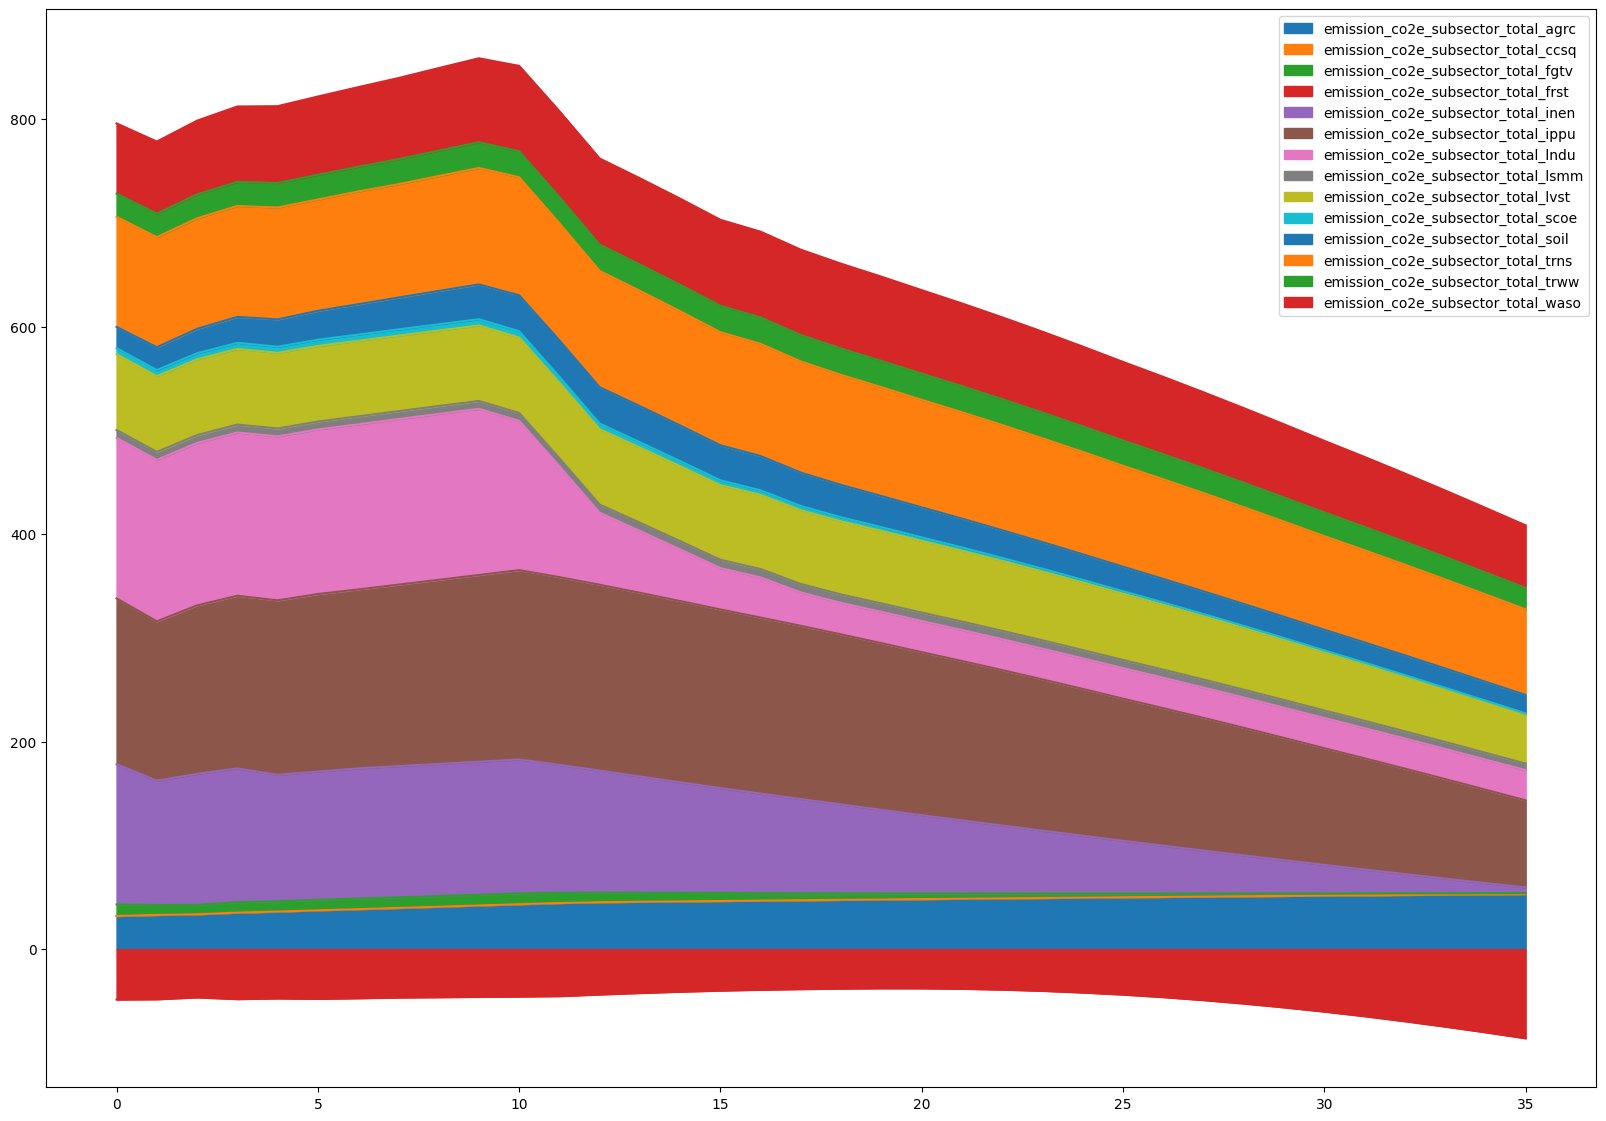

In [53]:
region = "mexico"

#df_plot

df_plot = df_out
    #df_out[sa.model_attributes.dim_region].isin([region])
    #& df_out[sa.model_attributes.dim_primary_id].isin([primary_id])



fields_plot = [x for x in df_plot.columns if ("emission_co2e_subsector_total" in x)]



fig, ax = plt.subplots(figsize = (20, 14))
df_plot[fields_plot].plot.area(ax = ax)


In [74]:
#df_out["emission_co2e_subsector_total_lsmm"]
df_run_information = pd.read_csv("/Users/jsyme/Documents/Projects/git_jbus/sisepuede/out/sisepuede_run_2023-10-13T01;33;54.419019/aws_run_information.csv")
df_run_information[
    df_run_information["region"].isin(["mexico"])
    & [str(primary_id) in x for x in list(df_run_information["primary_id"])]
]

,launch_index,instance_id,region,primary_id,random_seed,ip_address,n_launch_tries
1418,1418,i-0c233afcd3893b91c,mexico,"559565,559566,559567,559568,559569,559570,5595...",6401745,10.22.128.109,1


In [82]:
df_check_full_experiment = pd.read_csv("/Users/jsyme/Downloads/61c0ff9d-4024-42cd-aa4c-8eb2d03910b4.csv", nrows = 10000)
df_check_full_experiment[df_check_full_experiment["region"].isin(["mexico"])][["primary_id", "emission_co2e_subsector_total_lvst"]]

,primary_id,emission_co2e_subsector_total_lvst
432,0,73.041761
433,0,72.998398
434,0,72.949362
435,0,72.897254
436,0,72.859084
...,...,...
9535,559566,55.241439
9536,559566,53.813313
9537,559566,52.357631
9538,559566,50.880840


In [84]:
df_in = pd.read_csv("/Users/jsyme/Documents/Projects/git_jbus/sisepuede_launcher/sisepuede_run_2023-10-13t01;33;54.419019/model_input/region=mexico/model_input_1418/data.csv")
df_out = pd.read_csv("/Users/jsyme/Documents/Projects/git_jbus/sisepuede_launcher/sisepuede_run_2023-10-13t01;33;54.419019/model_output/region=mexico/model_output_1418/data.csv")


In [86]:
df_out["emission_co2e_subsector_total_lvst"]

0      73.041761
1      72.998398
2      72.949362
3      72.897254
4      72.859084
         ...    
463    54.674824
464    52.796107
465    50.900074
466    48.997007
467    47.149094
Name: emission_co2e_subsector_total_lvst, Length: 468, dtype: float64

In [30]:
len(set(sisepuede.database.db.dict_iterative_database_tables.get("MODEL_OUTPUT").columns))
fp = "/Users/jsyme/Documents/Projects/git_jbus/lac_decarbonization/out/sisepuede_run_2023-07-08T01;34;53.827024/sisepuede_run_2023-07-08T01;34;53.827024_output_database.sqlite"

engine = sqlalchemy.create_engine(f"sqlite:///{fp}")


In [110]:
fp = "/Users/jsyme/Documents/Projects/git_jbus/sisepuede/tmp/nemomod_intermediate_database_ORIG.sqlite"
engine_orig = sqlalchemy.create_engine(f"sqlite:///{fp}")

In [113]:
df_prod = sqlutil.sql_table_to_df(engine_orig, "vproductionbytechnologyannual")


In [117]:
df_prod[df_prod["y"].isin(["1001"]) & df_prod["f"].isin(["fuel_coal"])]

,r,t,f,y,val,solvedtm
974,colombia,me_coal,fuel_coal,1001,2534.541279,2023-07-11 22:26:29.493


In [22]:
ft = sisepuede.experimental_manager.dict_future_trajectories.get(region)
#?ft.generate_future_from_lhs_vector

In [32]:
region = "brazil"
lhs_design_cur = sisepuede.experimental_manager.dict_lhs_design.get(region)
df_lhs_l, df_lhs_x = lhs_design_cur.retrieve_lhs_tables_by_design(
    0,
    return_type = pd.DataFrame
)
keep_futures = [0, 1]

df_lhs_l = (
    df_lhs_l[
        df_lhs_l[sisepuede.key_future].isin(keep_futures)
    ] 
    if (df_lhs_l is not None) 
    else df_lhs_l
)
# Xs
df_lhs_x = (
    df_lhs_x[
        df_lhs_x[sisepuede.key_future].isin(keep_futures)
    ] 
    if (df_lhs_x is not None) 
    else df_lhs_x
)

##  Optional Export of a Regionj to `temporary_full_inputs`

In [35]:
region = "brazil"
df_in = sisepuede.experimental_manager.dict_future_trajectories.get(region).generate_future_from_lhs_vector(None, None, 15, baseline_future_q = False)#True)
df_in = sisepuede.experimental_manager.dict_future_trajectories.get(region).generate_future_from_lhs_vector(
    df_lhs_x, 
    df_row_lhc_sample_l = df_lhs_l, 
    future_id = 1, 
    baseline_future_q = False
)#True)

if False:
    # write to output for testing
    df_in.to_csv(
        os.path.join(sisepuede.file_struct.dir_tmp, "temporary_full_inputs.csv"),
        index = None,
        encoding = "UTF-8"
    )

# Export Model Results to CSVs for Tableau

In [10]:
model_afolu = sisepuede.models.model_afolu
model_circecon = sisepuede.models.model_circecon
model_energy = sisepuede.models.model_energy
model_ippu = sisepuede.models.model_ippu

import sqlalchemy
# precursor function - can integrate with sisepuede or add in
def format_inputs(
    modvars_extract: Union[List[str], None],
    engine: sqlalchemy.engine.Engine,
    sisepuede_obj: ssp.SISEPUEDE,
    chunk_size: int = 10,
    force_overwrite_existing_primary_keys: bool = False,
    regions: Union[List[str], None] = None,
    table_name_attribute_primary: Union[str, None] = None,
    table_name_output: Union[str, None] = None,
) -> pd.DataFrame:
    """
    Retrieve inputs for merge
    
    Function Arguments
    ------------------
    """
    
    # table names
    table_name_attribute_primary = (
        sisepuede_obj.database.table_name_attribute_primary
        if not isinstance(table_name_attribute_primary, str)
        else table_name_attribute_primary
    )
    table_name_output = (
        sisepuede_obj.database.table_name_output
        if not isinstance(table_name_output, str)
        else table_name_output
    )
    
    # initialize regions
    field_region = sisepuede.key_region
    query = f"SELECT DISTINCT {field_region} FROM {table_name_output};"
    regions_avail = sqlutil.fetch_query_as_df(query, engine)
    
    # set and filter regions
    regions = (
        [x for x in sisepuede_obj.regions if x in regions]
        if sf.islistlike(regions)
        else sisepuede_obj.regions
    )
    regions = (
        [x for x in regions if x in list(regions_avail[field_region])]
        if regions_avail is not None
        else None
    )
    
    # get primary id info
    field_primary = sisepuede.key_primary
    query = f"SELECT DISTINCT {field_primary} FROM {table_name_output};"
    primary_ids_avail = sqlutil.fetch_query_as_df(query, engine)
    primary_ids_avail = (
        primary_ids_avail[field_primary]
        if primary_ids_avail is not None
        else None
    )
    
    
    # return none?
    return_none = regions is None
    return_none |= (len(regions) == 0) if (not return_none) else return_none
    return_none |= not (sf.islistlike(modvars_extract) | (modvars_extract is None))
    return_none |= primary_ids_avail is None
    return_none |= (len(primary_ids_avail) == 0) if (not return_none) else return_none
    
    if return_none:
        return None
    
    
    ##  PRIMARY SELECTION
    
    df_primary_keys = sisepuede_obj.odpt_primary.get_indexing_dataframe(
        key_values = primary_ids_avail
    )
    primary_keys = sisepuede_obj.get_primary_keys(list(df_primary_keys[sisepuede_obj.key_primary]))
    all_designs = list(df_primary_keys[sisepuede_obj.key_design].unique())
    
    # initializations
    df_out = []
    df_out_primary = []
    iterate_outer = 0

    # available indices and resolution
    idt = sisepuede_obj.database.db.dict_iterative_database_tables.get(
        sisepuede_obj.database.table_name_input
    )
    index_conflict_resolution = None
    index_conflict_resolution = "write_replace" if (force_overwrite_existing_primary_keys or (idt.index_conflict_resolution == "write_replace")) else None
    set_available_ids = idt.available_indices


    # 
    fields_ext = None
    if modvars_extract is not None:
        fields_ext = sisepuede_obj.model_attributes.build_variable_fields(modvars_extract)
    
    
    for region in regions:

        iterate_inner = 0

        # retrieve region specific future trajectories and lhs design
        future_trajectories_cur = sisepuede_obj.experimental_manager.dict_future_trajectories.get(region)
        lhs_design_cur = sisepuede_obj.experimental_manager.dict_lhs_design.get(region)
        region_out = sisepuede_obj.get_output_region(region)

        sisepuede_obj._log(f"\n***\t BUILDING INPUTS FOR REGION {region}\t***\n", type_log = "info")


        for design in all_designs:

            df_lhs_l, df_lhs_x = lhs_design_cur.retrieve_lhs_tables_by_design(
                design,
                return_type = pd.DataFrame
            )

            # get reduced set of primary keys
            df_primary_keys_cur_design = df_primary_keys[
                df_primary_keys[sisepuede_obj.key_design] == design
            ]
            keep_futures = sorted(list(set(df_primary_keys_cur_design[sisepuede_obj.key_future])))

            # reduce lhs tables - LEs
            df_lhs_l = (
                df_lhs_l[
                    df_lhs_l[sisepuede_obj.key_future].isin(keep_futures)
                ] 
                if (df_lhs_l is not None) 
                else df_lhs_l
            )
            
            # Xs
            df_lhs_x = (
                df_lhs_x[
                    df_lhs_x[sisepuede_obj.key_future].isin(keep_futures)
                ] 
                if (df_lhs_x is not None) 
                else df_lhs_x
            )

            # next, loop over futures
            #  Note that self.generate_future_from_lhs_vector() will return a table for all strategies
            #  associated with the future, so we can prevent redundant calls by running all strategies
            #  that need to be run for a given future

            for future in keep_futures:

                # determine if baseline future and fetch lhs rows
                base_future_q = (future == sisepuede_obj.baseline_future)
                lhs_l = df_lhs_l[df_lhs_l[sisepuede_obj.key_future] == future].iloc[0] if ((df_lhs_l is not None) and not base_future_q) else None
                lhs_x = df_lhs_x[df_lhs_x[sisepuede_obj.key_future] == future].iloc[0] if ((df_lhs_x is not None) and not base_future_q) else None

                # generate the futures and get available strategies
                df_input = future_trajectories_cur.generate_future_from_lhs_vector(
                    lhs_x,
                    df_row_lhc_sample_l = lhs_l,
                    future_id = future,
                    baseline_future_q = base_future_q
                )
                all_strategies = sorted(list(
                    set(df_input[sisepuede_obj.key_strategy])
                ))


                for strategy in all_strategies:

                    # get primary id info
                    df_primary_keys_cur_design_fs = df_primary_keys_cur_design[
                        (df_primary_keys_cur_design[sisepuede_obj.key_future] == future) &
                        (df_primary_keys_cur_design[sisepuede_obj.key_strategy] == strategy)
                    ].reset_index(drop = True)

                    id_primary = df_primary_keys_cur_design_fs[sisepuede_obj.key_primary]
                    id_primary = int(id_primary.iloc[0]) if (len(id_primary) > 0) else None
                    write_q = ((region_out, id_primary) not in set_available_ids) or (index_conflict_resolution == "write_replace")
                    tup = (region_out, id_primary)

                    if (id_primary in primary_keys) and write_q:

                        # filter the data frame down
                        df_input_cur = (
                            df_input[
                                df_input[sisepuede_obj.key_strategy].isin([strategy])
                            ]
                            .copy()
                            .reset_index(drop = True)
                            .sort_values(by = [sisepuede_obj.model_attributes.dim_time_period])
                            .drop([x for x in df_input.columns if x in sisepuede_obj.keys_index], axis = 1)
                        )
                        
                        if fields_ext is not None:
                            df_input_cur.drop(
                                [
                                    x for x in df_input_cur.columns 
                                    if (x not in fields_ext)
                                    & (x != sisepuede_obj.model_attributes.dim_time_period) 
                                ], 
                                axis = 1,
                                inplace = True
                            )

                        df_input_cur = sf.add_data_frame_fields_from_dict(
                            df_input_cur,
                            {
                                sisepuede_obj.key_region: region_out,
                                sisepuede_obj.key_primary: id_primary
                            },
                            prepend_q = True
                        )
                        df_out.append(df_input_cur)
        

    df_out = (
        pd.concat(df_out, axis = 0).reset_index(drop = True)
        if len(df_out) > 0
        else None
    )
    
    return df_out



def get_modvars_to_save(
) -> List[str]:

    # get model variables to keep
    modvars = []
    for subsec in ["Economy", "General"]:
        modvars += sisepuede.model_attributes.get_subsector_variables(subsec, var_type = "input")[1]
    

    ##  AFOLU variables
    
    modvars += [
        model_afolu.modvar_agrc_emissions_ch4_rice,
        model_afolu.modvar_agrc_frac_residues_removed,
        model_afolu.modvar_agrc_frac_no_till, # conservation ag
        model_afolu.modvar_lndu_emissions_conv,
        model_afolu.modvar_lndu_frac_pastures_improved,
        model_afolu.modvar_lsmm_rf_biogas,
        model_afolu.modvar_lvst_ef_ch4_ef,
    ]
    
    modvars += model_afolu.modvar_list_lvst_mm_fractions
    
        
    ##  CircularEconomy variables
    modvars += [
        v.get("treatment_fraction") 
        for v in model_circecon.dict_trww_categories_to_wali_fraction_variables.values()
    ]
    
    modvars += [
        model_circecon.modvar_trww_rf_biogas_recovered,
        model_circecon.modvar_waso_frac_landfill_gas_ch4_to_energy,
        model_circecon.modvar_waso_frac_recovered_for_energy_incineration_isw,
        model_circecon.modvar_waso_frac_recovered_for_energy_incineration_msw,
        model_circecon.modvar_waso_rf_landfill_gas_recovered,
        model_circecon.modvar_waso_waste_per_capita_scalar
    ]
    
    
    ##  Energy variables
    
    modvars += [
        model_energy.modvar_fgtv_frac_non_fugitive_flared,
        model_energy.modvar_fgtv_frac_reduction_fugitive_leaks,
        model_energy.modvar_inen_demscalar,
        model_energy.modvar_enfu_efficiency_factor_industrial_energy,

        # SCOE
        model_energy.modvar_scoe_demscalar_elec_energy_demand,
        model_energy.modvar_scoe_demscalar_heat_energy_demand,
        model_energy.modvar_scoe_efficiency_fact_heat_en_coal,
        model_energy.modvar_scoe_efficiency_fact_heat_en_diesel,
        model_energy.modvar_scoe_efficiency_fact_heat_en_electricity,
        model_energy.modvar_scoe_efficiency_fact_heat_en_gasoline,
        model_energy.modvar_scoe_efficiency_fact_heat_en_hydrogen,
        model_energy.modvar_scoe_efficiency_fact_heat_en_kerosene,
        model_energy.modvar_scoe_efficiency_fact_heat_en_natural_gas,
        model_energy.modvar_scoe_efficiency_fact_heat_en_hgl,
        model_energy.modvar_scoe_efficiency_fact_heat_en_solid_biomass,
        
        # TRNS
        model_energy.modvar_trns_fuel_efficiency_biofuels,
        model_energy.modvar_trns_fuel_efficiency_diesel,
        model_energy.modvar_trns_fuel_efficiency_gasoline,
        model_energy.modvar_trns_fuel_efficiency_hgl,
        model_energy.modvar_trns_fuel_efficiency_hydrogen,
        model_energy.modvar_trns_fuel_efficiency_kerosene,
        model_energy.modvar_trns_fuel_efficiency_natural_gas,
        model_energy.modvar_trns_electrical_efficiency
    ]
    
    ##  IPPU variables
    
    modvars += [
        model_ippu.modvar_ippu_clinker_fraction_cement,
        model_ippu.modvar_ippu_capture_efficacy_co2,
        model_ippu.modvar_ippu_capture_prevalence_co2,
        model_ippu.modvar_ippu_scalar_production
    ]
    
    # add in FC emission factors
    modvars += sum(model_ippu.dict_fc_ef_modvars_by_type.values(), [])
    
    
    
    
    return modvars


attr_strat = sa.model_attributes.dict_attributes.get("dim_strategy_id")
attr_strat_code = sa.model_attributes.dict_attributes.get("strategy_code")
set(attr_strat.table[attr_strat_code.key]) - set(attr_strat_code.key_values)

In [28]:
df_tmp = pd.read_csv(
    "/Users/jsyme/Documents/Projects/git_jbus/sisepuede/out/sisepuede_summary_results_run_sisepuede_run_2023-09-28T11;36;58.322719/sisepuede_results_sisepuede_run_2023-09-28T11;36;58.322719_WIDE_OUTPUTS_ONLY.csv"
)

df_tmp["primary_id"].unique()

array([     0,  14014, 119119, 122122, 124124, 125125, 127127])

In [12]:
import sql_utilities as sqlutil

vars_extract = sisepuede.model_attributes.build_variable_fields("NemoMod Discounted Capital Investment")
df_out = sisepuede.read_output(None)
engine = sqlalchemy.create_engine(f"sqlite:///{sisepuede.fp_base_output_raw}.sqlite")


# check output directory 
dir_pkg = os.path.join(sisepuede.file_struct.dir_out, f"sisepuede_summary_results_run_{sisepuede.id_fs_safe}")
os.makedirs(dir_pkg) if not os.path.exists(dir_pkg) else None



# add in input variables
modvars_save = get_modvars_to_save()
df_in_merge = format_inputs(modvars_save, engine, sisepuede) # TEMP


subsectors = []
for sector in sorted(list(set(sisepuede.model_attributes.all_sectors))):#["Energy", "IPPU", ]:
    subsectors += sisepuede.model_attributes.get_sector_subsectors(sector)
attr_subsec = sisepuede.model_attributes.dict_attributes.get("abbreviation_subsector")
dict_subsector_name_to_abv = attr_subsec.field_maps.get(f"subsector_to_{attr_subsec.key}")


# index fields
fields_ind = [
    sisepuede.key_primary,
    sisepuede.key_region,
    sisepuede.key_time_period
]


# build variable extract
vars_extract += [f"emission_co2e_subsector_total_{dict_subsector_name_to_abv.get(x)}" for x in subsectors]
for subsector in subsectors:
    modvars_cur = sisepuede.model_attributes.get_subsector_variables(
        subsector,
        var_type = "output"
    )[1]

    vars_cur = sum([sisepuede.model_attributes.dict_model_variables_to_variables.get(x) for x in modvars_cur], [])
    vars_extract += vars_cur
    
vars_extract += [x for x in df_in_merge.columns if x not in fields_ind]



# export outputs only before merge
flds_ind_out = [x for x in fields_ind if x in df_out.columns]
flds_sort_out = sorted([x for x in vars_extract if x in df_out.columns])

df_out[flds_ind_out + flds_sort_out].to_csv(
    os.path.join(dir_pkg, f"sisepuede_results_{sisepuede.id_fs_safe}_WIDE_OUTPUTS_ONLY.csv"),
    index = None,
    encoding = "UTF-8"
)


# export inputs only before merge
flds_ind_in = [x for x in fields_ind if x in df_in_merge.columns]
flds_sort_in = sorted([x for x in vars_extract if x in df_in_merge.columns])

df_in_merge[flds_ind_in + flds_sort_in].to_csv(
    os.path.join(dir_pkg, f"sisepuede_results_{sisepuede.id_fs_safe}_WIDE_INPUTS_ONLY.csv"),
    index = None,
    encoding = "UTF-8"
)


# finally, merge and export
df_melt = pd.merge(
    df_out,
    df_in_merge
)
fields_ext = sorted([x for x in vars_extract if x in df_melt.columns])
df_melt = df_melt[fields_ind + fields_ext];

df_melt.to_csv(
    os.path.join(dir_pkg, f"sisepuede_results_{sisepuede.id_fs_safe}_WIDE_INPUTS_OUTPUTS.csv"),
    index = None,
    encoding = "UTF-8"
)


# melt
"""
df_melt = pd.melt(
    df_melt,
    fields_ind,
    fields_ext
)

    
df_melt.to_csv(
    os.path.join(dir_pkg, f"sisepuede_results_{sisepuede.id_fs_safe}_LONG.csv"),
    index = None,
    encoding = "UTF-8"
)

""";

for tab in ["ATTRIBUTE_PRIMARY", "ATTRIBUTE_STRATEGY"]:
    sisepuede.database.db.read_table(tab).to_csv(
        os.path.join(dir_pkg, f"{tab}.csv"),
        index = None,
        encoding = "UTF-8"
    )


df_primary = sisepuede.odpt_primary.get_indexing_dataframe(sorted(list(df_out[sisepuede.key_primary].unique())))
df_primary.to_csv(
    os.path.join(dir_pkg, f"ATTRIBUTE_PRIMARY.csv"),
    index = None,
    encoding = "UTF-8"
)


2023-09-28 18:48:04,828 - INFO - 
***	 BUILDING INPUTS FOR REGION argentina	***

2023-09-28 18:48:07,252 - INFO - 
***	 BUILDING INPUTS FOR REGION bolivia	***

2023-09-28 18:48:09,308 - INFO - 
***	 BUILDING INPUTS FOR REGION brazil	***

2023-09-28 18:48:11,418 - INFO - 
***	 BUILDING INPUTS FOR REGION chile	***

2023-09-28 18:48:13,361 - INFO - 
***	 BUILDING INPUTS FOR REGION colombia	***

2023-09-28 18:48:15,312 - INFO - 
***	 BUILDING INPUTS FOR REGION costa_rica	***

2023-09-28 18:48:17,619 - INFO - 
***	 BUILDING INPUTS FOR REGION dominican_republic	***

2023-09-28 18:48:19,791 - INFO - 
***	 BUILDING INPUTS FOR REGION ecuador	***

2023-09-28 18:48:21,968 - INFO - 
***	 BUILDING INPUTS FOR REGION el_salvador	***

2023-09-28 18:48:24,090 - INFO - 
***	 BUILDING INPUTS FOR REGION guatemala	***

2023-09-28 18:48:26,048 - INFO - 
***	 BUILDING INPUTS FOR REGION honduras	***

2023-09-28 18:48:28,273 - INFO - 
***	 BUILDING INPUTS FOR REGION jamaica	***

2023-09-28 18:48:30,184 - INFO 

In [13]:
2+2

4

# Plot output

In [12]:
df_out_all = sisepuede.read_output(None)

"""
df_out_all[
    df_out_all["primary_id"].isin([127127])
][[x for x in df_out_all.columns if x.startswith("emission_co2e_subsector_total")]]
""";

In [ ]:
"""
import sqlalchemy
import sql_utilities as squ
fp = "/Users/jsyme/Documents/Projects/git_jbus/lac_decarbonization/out/sisepuede_run_2023-07-05T02;43;25.818306/sisepuede_run_2023-07-05T02;43;25.818306_output_database.sqlite"
engine = sqlalchemy.create_engine(f"sqlite:///{fp}")
df = squ.sql_table_to_df(engine, "MODEL_OUTPUT")
""";


In [110]:
# get_lhs_trajes() is defined above, just a shortcut
dict_filt_check = {'design_id': 3, 'future_id': 11, 'strategy_id': 5009}
lhs_l, lhs_x, baseline_q = get_lhs_trajes(dict_filt_check)
lhs_l.get(1094)

0.6095540665607345

In [24]:
prims = df_out_all[df_out_all[sisepuede.key_region].isin([region])]["primary_id"].unique()
[sisepuede.odpt_primary.get_dims_from_key(x) for x in prims]

[(0, 5009, 0),
 (0, 5009, 11),
 (0, 5009, 473),
 (0, 5009, 889),
 (3, 5009, 0),
 (3, 5009, 473),
 (3, 5009, 889)]

In [14]:
df_out_all["region"].unique()

array(['mexico', 'peru', 'dominican_republic'], dtype=object)

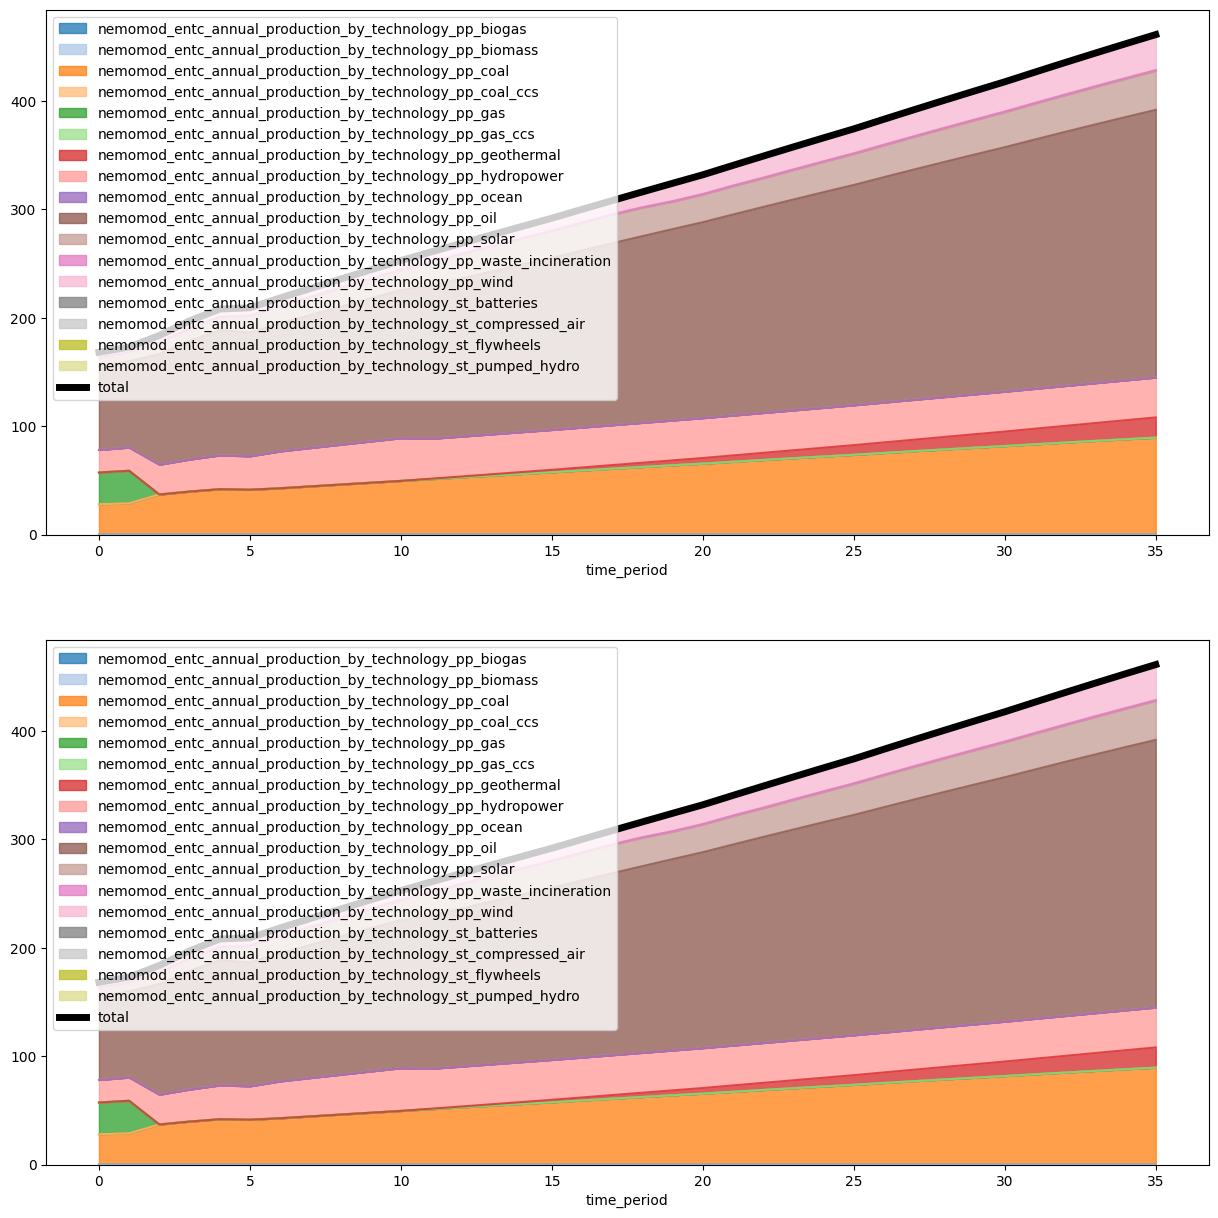

In [16]:

region = "dominican_republic"
df_out = df_out_all[
    df_out_all[sisepuede.key_region].isin([region])
]


# 3008, 3009, 303
strat_id, strat_id_intervention = 0, 0# 0, 5009
future_id, future_id_intervention = 0, 0#875
design_id = 0



def get_lhs_trajes(
    dict_filt: dict,
) -> Tuple[pd.Series, pd.Series, bool]:
    """
    Get LHS trajectories for input to generator
    """
    future_trajectories_cur = sisepuede.experimental_manager.dict_future_trajectories.get(region)
    lhs_design_cur = sisepuede.experimental_manager.dict_lhs_design.get(region)
    region_out = sisepuede.get_output_region(region)

    design = dict_filt.get(sisepuede.key_design)
    future = dict_filt.get(sisepuede.key_future)
    strategy = dict_filt.get(sisepuede.key_strategy)

    df_lhs_l, df_lhs_x = lhs_design_cur.retrieve_lhs_tables_by_design(design, return_type = pd.DataFrame)

    # reduce lhs tables - LEs
    df_lhs_l = (
        df_lhs_l[df_lhs_l[sisepuede.key_future].isin([future])] 
        if (df_lhs_l is not None) 
        else df_lhs_l
    )
    # Xs
    df_lhs_x = (
        df_lhs_x[df_lhs_x[sisepuede.key_future].isin([future])] 
        if (df_lhs_x is not None) 
        else df_lhs_x
    )


    ##  GENERATE INPUT BY FUTURE

    # determine if baseline future and fetch lhs rows
    base_future_q = (future == sisepuede.baseline_future)
    lhs_l = (
        df_lhs_l[df_lhs_l[sisepuede.key_future] == future].iloc[0] 
        if ((df_lhs_l is not None) and not base_future_q) 
        else None
    )
    lhs_x = (
        df_lhs_x[df_lhs_x[sisepuede.key_future] == future].iloc[0] 
        if ((df_lhs_x is not None) and not base_future_q) 
        else None
    )
    
    tup_out = lhs_l, lhs_x, base_future_q
    
    return tup_out





# set dictionaries
dict_filt2 = {
    sisepuede.key_design: design_id,
    sisepuede.key_future: future_id,
    sisepuede.key_strategy: strat_id,
}
dict_filt_intervention = {
    sisepuede.key_design: design_id,
    sisepuede.key_future: future_id_intervention,
    sisepuede.key_strategy: strat_id_intervention,
}
# update if any are missing
for k, val in dict_filt.items():
    if k not in dict_filt2.keys():
        dict_filt2.update({k: val[0]})
    if k not in dict_filt_intervention.keys():
        dict_filt_intervention.update({k: val[0]})
        


primary_id = sisepuede.odpt_primary.get_key_value(**dict_filt2)
df_filt = df_out[
    df_out[sisepuede.key_primary].isin([primary_id])
]

# get_lhs_trajes() is defined above, just a shortcut
lhs_l, lhs_x, baseline_q = get_lhs_trajes(dict_filt2)
df_in_filt = sisepuede.experimental_manager.dict_future_trajectories.get(region).generate_future_from_lhs_vector(
    lhs_x, 
    df_row_lhc_sample_l = lhs_l, 
    future_id = future_id, 
    baseline_future_q = baseline_q,
)
df_in_filt = (
    df_in_filt[
        df_in_filt[sisepuede.key_strategy].isin([strat_id])
    ]
    .reset_index(drop = True)
)
        
        
primary_id_intervention = sisepuede.odpt_primary.get_key_value(**dict_filt_intervention)
df_filt_intervention = df_out[
    df_out[sisepuede.key_primary].isin([primary_id_intervention])
]

# get_lhs_trajes() is defined above, just a shortcut
lhs_l_int, lhs_x_int, baseline_q_int = get_lhs_trajes(dict_filt_intervention)
df_in_filt_intervention = sisepuede.experimental_manager.dict_future_trajectories.get(region).generate_future_from_lhs_vector(
    lhs_x_int, 
    df_row_lhc_sample_l = lhs_l_int, 
    future_id = future_id_intervention, 
    baseline_future_q = baseline_q_int,
)
df_in_filt_intervention = (
    df_in_filt_intervention[
        df_in_filt_intervention[sisepuede.key_strategy].isin([strat_id_intervention])
    ]
    .reset_index(drop = True)
)




############################
###                      ###
###    BEGIN PLOTTING    ###
###                      ###
############################

fig, ax = plt.subplots(2, 1, figsize = (15, 15))
#ax[0].set_ylim(-150, 350)
#ax[0].set_ylim(0, 900)
#ax[1].set_ylim(0, 900)

palette_func = plt.cm.tab20#plt.cm.hsv

flds = [sisepuede.key_time_period]
if False:
    flds += [
        x for x in df_filt.columns 
        if x.startswith("emission_co2e_subsector_total") 
        and (
            False
            or ("ccsq" in x) 
            or ("entc" in x)
            or ("enfu" in x)
            or ("fgtv" in x)
            or ("inen" in x)
            or ("scoe" in x)
            or ("trns" in x)
        )
    ]
    
if False:
    flds += [
        x for x in df_filt.columns 
        if x.startswith("emission_co2e_subsector_total") 
        and (
            #True
            ("agrc" in x)
            or ("frst" in x)
            or ("lndu" in x)
            or ("lsmm" in x)
            or ("lvst" in x)
            or ("soil" in x)
            #("entc" in x) 
            #or ("scoe" in x)
            #or ("lsmm" in x)
            #or ("soil" in x)
            #or ("frst" in x)
            #or ("lndu" in x)
        )
    ]
    
if False:
    flds = [x for x in flds if "trns" in x]
    
if True:
    flds += [
        x for x in df_filt.columns 
        if x.startswith("emission_co2e_") 
        and (
            True
            #and ("lvst" in x)
            #or ("fgtv" in x)
            #and ("subsector_total" not in x)
            and ("subsector_total" in x)
            and 
            (
                True
                #("lvst" in x)
                #or ("lsmm" in x)
                #or ("soil" in x)
            )
        )
    ]

if False:
    flds += [
        x for x in df_filt.columns 
        if x.startswith("energy_demand_enfu_") 
        and (
            True
            #("entc" in x)
            #or ("fgtv" in x)
            #("inen" in x)
            & ("subsector" in x)
            & ("electricity" in x)
        )
    ]

if False:
    #flds = [x for x in df_filt.columns if x.startswith("energy_demand_enfu") and ("total" in x) and ("subsector" not in x)]# and (("natural_gas" in x) or ("crude" in x) or ("electricity" in x) or ("hydrogen" in x))]
    cat = "rail_passenger"
    pre = "energy_consumption_trns"
    fld_ignore = f"{pre}_{cat}"
    flds = [sisepuede.key_time_period] + [x for x in df_filt.columns if x.startswith(pre) and (cat in x) and (x != fld_ignore)]
    #flds = [x for x in df_filt.columns if x.startswith("passenger_distance")]

add_total = True
plot_from_modvar = True

if True:

    # AFOLU
    #modvar_plot = sisepuede.models.model_afolu.modvar_lndu_area_by_cat
    #modvar_plot = sisepuede.models.model_afolu.modvar_lndu_area_converted_from_type
    #modvar_plot = sisepuede.models.model_afolu.modvar_lndu_area_by_cat
    #modvar_plot = sisepuede.models.model_afolu.modvar_soil_emissions_co2_urea
    #modvar_plot = sisepuede.models.model_afolu.modvar_lvst_pop
    #modvar_plot = sisepuede.models.model_afolu.modvar_lvst_adjusted_equivalent_exports

    #modvar_plot = sisepuede.models.model_afolu.modvar_frst_emissions_co2_sequestration
    #modvar_plot = sisepuede.models.model_afolu.modvar_lndu_emissions_conv
    #modvar_plot = sisepuede.models.model_afolu.modvar_lvst_emissions_ch4_ef
    #modvar_plot = sisepuede.models.model_afolu.modvar_lsmm_emissions_ch4
    
    
    # ENERGY
    modvar_plot = sisepuede.models.model_electricity.modvar_entc_nemomod_emissions_co2_mne
    modvar_plot = sisepuede.models.model_electricity.modvar_entc_nemomod_production_by_technology
    #modvar_plot = sisepuede.models.model_energy.modvar_trns_energy_consumption_total
    #modvar_plot = sisepuede.models.model_energy.modvar_trns_passenger_distance_traveled
    #modvar_plot = sisepuede.models.model_energy.modvar_trns_passenger_distance_traveled
    #modvar_plot = sisepuede.models.model_energy.modvar_trde_demand_pkm
    #modvar_plot = sisepuede.models.model_energy.modvar_trns_mass_distance_traveled
    #modvar_plot = sisepuede.models.model_energy.modvar_fgtv_emissions_ch4
    #modvar_plot = sisepuede.models.model_energy.modvar_enfu_exports_fuel_adjusted
    #modvar_plot = sisepuede.models.model_energy.modvar_enfu_energy_demand_by_fuel_total
    #modvar_plot = sisepuede.models.model_energy.modvar_enfu_energy_demand_by_fuel_trns
    #modvar_plot = sisepuede.models.model_electricity.modvar_entc_nemomod_production_by_technology
    #modvar_plot = sisepuede.models.model_energy.modvar_fgtv_emissions_ch4
    #modvar_plot = sisepuede.models.model_energy.modvar_trns_vehicle_distance_traveled_electricity
    
    #IPPU
    #modvar_plot = sisepuede.models.model_ippu.modvar_ippu_qty_total_production
    
    
    
    # NO INTERVENTION
    
    df = sisepuede.model_attributes.extract_model_variable(
        df_filt,
        modvar_plot
    )
    df = pd.concat([df_filt[[sisepuede.key_time_period]].reset_index(drop = True), df], axis = 1)
    df = df[[x for x in df.columns if ("nuclear" not in x) and ("crude" not in x)]]
    df = df_filt[flds] if (not plot_from_modvar) else df
    if len(df) > 0:
        for k in df.columns:
            vec = np.array(df[k])
            bnds = (0, np.inf) if (vec[-1] >= 0) else (-np.inf, 0)
            if (max(vec) > 0) and (min(vec) < 0):
                k0 = f"{k}_positive"
                k1 = f"{k}_negative"
                df[k0] = sf.vec_bounds(np.array(df[k]), (0, np.inf))
                df[k1] = sf.vec_bounds(np.array(df[k]), (-np.inf, 0))
                df.drop([k], axis = 1, inplace = True)
            else:
                df[k] = sf.vec_bounds(np.array(df[k]), bnds)
    
    m, n = df.shape
    colors = [palette_func(x/n) for x in range(n)]
    
    alpha = 1 if not add_total else 0.75
    df.plot.area(x = sisepuede.key_time_period, ax = ax[0], color = colors, alpha = alpha)
    if add_total:
        df["total"] = df.drop([sisepuede.key_time_period], axis = 1).sum(axis = 1)
        df[[sisepuede.key_time_period, "total"]].plot(x = sisepuede.key_time_period, ax = ax[0], color = "black", linewidth = 5)
    df_plot_noint = df.copy()
        
        
    # INTERVENTION
    
    df = sisepuede.model_attributes.extract_model_variable(
        df_filt_intervention,
        modvar_plot
    )
    df = pd.concat([df_filt_intervention[[sisepuede.key_time_period]].reset_index(drop = True), df], axis = 1)
    df = df[[x for x in df.columns if ("nuclear" not in x) and ("crude" not in x)]]
    df = df_filt_intervention[flds] if (not plot_from_modvar) else df
    
    if False:
        # UNCOMMENT TO USE DIFF
        vec = np.array(df[sisepuede.key_time_period])
        flds = [x for x in df.columns if (x != sisepuede.key_time_period)]
        df = pd.DataFrame(np.array(df_filt_intervention[flds]) - np.array(df_filt[flds]), columns = flds)
        df[sisepuede.key_time_period] = vec

    
    
    for k in df.columns:
        vec = np.array(df[k])
        bnds = (0, np.inf) if (vec[-1] >= 0) else (-np.inf, 0)
        if (max(vec) > 0) and (min(vec) < 0):
            k0 = f"{k}_positive"
            k1 = f"{k}_negative"
            df[k0] = sf.vec_bounds(np.array(df[k]), (0, np.inf))
            df[k1] = sf.vec_bounds(np.array(df[k]), (-np.inf, 0))
            df.drop([k], axis = 1, inplace = True)
        else:
            df[k] = sf.vec_bounds(np.array(df[k]), bnds)
    
    m, n = df.shape
    colors = [palette_func(x/n) for x in range(n)]
    
    alpha = 1 if not add_total else 0.75
    df.plot.area(x = sisepuede.key_time_period, ax = ax[1], color = colors, alpha = alpha)
    if add_total:
        df["total"] = df.drop([sisepuede.key_time_period], axis = 1).sum(axis = 1)
        df[[sisepuede.key_time_period, "total"]].plot(x = sisepuede.key_time_period, ax = ax[1], color = "black", linewidth = 5)
    df_plot_int = df.copy()
    #df.plot(ax = ax[1], color = colors)



In [28]:
cols = [x for x in df_in_filt_intervention.columns if x.startswith("pij_lndu_forests_primary_to")]
print(df_in_filt[cols].tail())
print("\n" + "*"*50 + "\n")
print(df_in_filt_intervention[cols].tail())

    pij_lndu_forests_primary_to_croplands  \
31                           4.233223e-07   
32                           4.210720e-07   
33                           4.189189e-07   
34                           4.168576e-07   
35                           4.153487e-07   

    pij_lndu_forests_primary_to_forests_mangroves  \
31                                            0.0   
32                                            0.0   
33                                            0.0   
34                                            0.0   
35                                            0.0   

    pij_lndu_forests_primary_to_forests_primary  \
31                                      0.99999   
32                                      0.99999   
33                                      0.99999   
34                                      0.99999   
35                                      0.99999   

    pij_lndu_forests_primary_to_forests_secondary  \
31                                       0.000001 

In [13]:
cols = [x for x in df_filt.columns if x.startswith("emission_co2e_subsector_total")]
print(df_filt[cols].sum(axis = 1).tail())
print(df_filt_intervention[cols].sum(axis = 1).tail())

31    233.106720
32    201.619615
33    169.999025
34    138.055531
35    105.766456
dtype: float64
103    435.715588
104    413.661197
105    391.332363
106    368.489714
107    345.629959
dtype: float64


In [31]:
cols = [x for x in df_in_filt.columns if x.startswith("cost_enfu")]
print(df_in_filt[cols].tail())
print(df_in_filt_intervention[cols].tail())

    cost_enfu_fuel_biofuels_usd_per_m3  cost_enfu_fuel_biogas_usd_per_mmbtu  \
31                           31.635833                                 22.0   
32                           31.635833                                 22.0   
33                           31.635833                                 22.0   
34                           31.635833                                 22.0   
35                           31.635833                                 22.0   

    cost_enfu_fuel_biomass_usd_per_tonne  cost_enfu_fuel_coal_usd_per_tonne  \
31                                209.78                         104.889167   
32                                209.78                         104.889167   
33                                209.78                         104.889167   
34                                209.78                         104.889167   
35                                209.78                         104.889167   

    cost_enfu_fuel_coke_usd_per_tonne  cost_enfu_f

In [26]:
# get_lhs_trajes() is defined above, just a shortcut
dfi = dict_filt_intervention.copy()
dfi.update({"future_id": 11})

lhs_l_int, lhs_x_int, baseline_q_int = get_lhs_trajes(dfi)

ftc = sisepuede.experimental_manager.dict_future_trajectories.get(region)
df_in_filt_intervention = ftc.generate_future_from_lhs_vector(
    lhs_x_int, 
    df_row_lhc_sample_l = lhs_l_int, 
    future_id = future_id_intervention, 
    baseline_future_q = baseline_q_int,
)
df_in_filt_intervention = (
    df_in_filt_intervention[
        df_in_filt_intervention[sisepuede.key_strategy].isin([strat_id_intervention])
    ]
    .reset_index(drop = True)
)




baseline_future_q:	True
baseline_future_q:	True
baseline_future_q:	True
baseline_future_q:	True
baseline_future_q:	True
baseline_future_q:	True
baseline_future_q:	True
baseline_future_q:	True
baseline_future_q:	True
baseline_future_q:	True
baseline_future_q:	True
baseline_future_q:	True
baseline_future_q:	True
baseline_future_q:	True
baseline_future_q:	True
baseline_future_q:	True
baseline_future_q:	True
baseline_future_q:	True
baseline_future_q:	True
baseline_future_q:	True
baseline_future_q:	True
baseline_future_q:	True
baseline_future_q:	True
baseline_future_q:	True
baseline_future_q:	True
baseline_future_q:	True
baseline_future_q:	True
baseline_future_q:	True
baseline_future_q:	True
baseline_future_q:	True
baseline_future_q:	True
baseline_future_q:	True
baseline_future_q:	True
baseline_future_q:	True
baseline_future_q:	True
baseline_future_q:	False
baseline_future_q:	True
baseline_future_q:	True
baseline_future_q:	False
baseline_future_q:	True
baseline_future_q:	True
baseline_futur

In [ ]:
lhs_l_int.get(1094)

0.6095540665607345

['frac_trns_pkm_dem_private_and_public_human_powered',
 'frac_trns_pkm_dem_private_and_public_powered_bikes',
 'frac_trns_pkm_dem_private_and_public_public',
 'frac_trns_pkm_dem_private_and_public_road_light',
 'frac_trns_pkm_dem_private_and_public_water_borne']

In [ ]:
import sampling_unit as su
importlib.reload(su)
#varnames = [
#    "cost_enfu_fuel_coal_usd_per_tonne",
#    "nemomod_enfu_renewable_energy_minimum_production_target_fuel_electricity"
#]
varnames = sisepuede.model_attributes.build_variable_fields("Private and Public Transportation Mode Share")


#df_ft = sisepuede.experimental_manager.dict_future_trajectories.get(region)
#df_ft = df_ft.input_database.copy()

df_ft = sisepuede.experimental_manager.base_input_database.database.copy()
df_ft = df_ft[
    df_ft["variable"].isin(varnames)
].reset_index(drop = True)
#df_ft["variable_trajectory_group_type"] = "lhs"
    
attr_strat = sisepuede.model_attributes.dict_attributes.get("dim_strategy_id")


future_trajectories_cur = su.FutureTrajectories(
    df_ft,
    {sisepuede.key_strategy: 0},
    5,
    dict_all_dims = {sisepuede.key_strategy: attr_strat.key_values}
)


samp = future_trajectories_cur.dict_sampling_units.get(87)

lhs_x = 0.9#future_trajectories_cur.get_df_row_element(lhs_x_int, 2)
lhs_l = 0.582#future_trajectories_cur.get_df_row_element(lhs_l_int_test, 2)


lhs_l_int_test = pd.Series({87: lhs_l})

df = future_trajectories_cur.generate_future_from_lhs_vector(
    pd.Series({87: lhs_x}),#lhs_x_int, 
    df_row_lhc_sample_l = lhs_l_int_test, 
    future_id = None, 
    baseline_future_q = False,
)[varnames + ["time_period", "strategy_id"]]

df[df["time_period"].isin([35])];


samp.generate_future(
    None,
    lhc_trial_l = lhs_l,
    baseline_future_q = False
)

(
    df[
        df["time_period"].isin([33, 34, 35])
        & df["strategy_id"].isin([5009])
    ]
    .drop(["time_period", "strategy_id"], axis = 1)
    .sum(axis = 1)
)


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 

4605    1.009179
4606    1.004789
4607    1.000000
dtype: float64

In [65]:
lhc_trial_x = lhs_x
lhc_trial_l = 1.0
baseline_future_q = False
constraints_mix_tg: tuple = (0, 1)
flatten_output_array: bool = False
vary_q: Union[bool, None] = None


vary_q = (
    samp.variable_trajectory_group_vary_q 
    if not isinstance(vary_q, bool) 
    else vary_q
)

# clean up some cases for None entries
baseline_comp = not sf.isnumber(lhc_trial_l)
baseline_comp |= (lhc_trial_l == 1) if not baseline_comp else False
baseline_future_q |= ((lhc_trial_x is None) & baseline_comp)
baseline_future_q |= (not vary_q)

lhc_trial_x = 1.0 if (lhc_trial_x is None) else lhc_trial_x
lhc_trial_l = 1.0 if (lhc_trial_l is None) else lhc_trial_l

# some additional checks for potential negative numbers
no_vary_x = (baseline_future_q | (lhc_trial_x < 0))
no_vary_l = (baseline_future_q | (lhc_trial_l < 0))
lhc_trial_x = 1.0 if (lhc_trial_x < 0) else lhc_trial_x
lhc_trial_l = 1.0 if (lhc_trial_l < 0) else lhc_trial_l

# initialization
all_strats = samp.dict_id_values.get(samp.key_strategy)
n_strat = len(all_strats)
strat_base = samp.dict_baseline_ids.get(samp.key_strategy)

# index by variable_specification at keys
dict_out = {}
rv = samp.uncertainty_ramp_vector


cat_mix = samp.dict_required_tg_spec_fields.get("mixing_trajectory")
cat_b0 = samp.dict_required_tg_spec_fields.get("trajectory_boundary_0")
cat_b1 = samp.dict_required_tg_spec_fields.get("trajectory_boundary_1")

# use mix between 0/1 (0 = 100% trajectory_boundary_0, 1 = 100% trajectory_boundary_1)
for vs in samp.variable_specifications[0:4]:

    # get scalar diff arrays, which are applied to baseline
    dict_scalar_diff_arrays = samp.dict_scalar_diff_arrays.get((vs, None))
    dict_var_info = samp.dict_variable_info.get((vs, None))

    # get any information 
    default = samp.dict_ordered_trajectory_arrays.get((vs, None))
    b0 = samp.dict_ordered_trajectory_arrays.get((vs, cat_b0))
    b1 = samp.dict_ordered_trajectory_arrays.get((vs, cat_b1))
    mix = samp.dict_ordered_trajectory_arrays.get((vs, cat_mix))

    # if any are missing, shift to None
    use_mix_q = not ((b0 is None) | (b1 is None) | (mix is None))
    if not use_mix_q:
        b0 = default
        b1 = default
        mix = 1.0

    dict_arrs = {
        cat_b0: b0,
        cat_b1: b1,
        cat_mix: mix,
        None: default,
    }

In [ ]:
vs

'frac_trns_pkm_dem_private_and_public_road_light'

In [ ]:
sum(list(samp.dict_ordered_trajectory_arrays.values()))

array([[1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       ...,
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.01577143, 1.00822857,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ]])

In [165]:
importlib.reload(ma)
importlib.reload(sf)
importlib.reload(ing)
importlib.reload(tba)
importlib.reload(dta)
importlib.reload(dtr)

regions_lac = [
    "argentina",
    "bahamas",
    "barbados",
    "belize",
    "bolivia",
    "brazil",
    "chile",
    "colombia",
    "costa_rica",
    "dominican_republic",
    "ecuador",
    "el_salvador",
    "guatemala",
    "guyana",
    "haiti",
    "honduras",
    "jamaica",
    "mexico",
    "nicaragua",
    "panama",
    "paraguay",
    "peru",
    "suriname",
    "trinidad_and_tobago",
    "uruguay",
    "venezuela"
]



year_0_ramp = 2025
dir_calibs = "/Users/jsyme/Documents/Projects/FY21/SWCHE131_1000/Data/calibrated_input_files_from_edmundo"
fp_inputs = os.path.join(dir_calibs, "input_all_sectors.csv")
df_input = pd.read_csv(fp_inputs)
field_region = "nation"

regions_run = [
    x for x in sorted(regions_lac) if x in list(df_input[field_region].unique())
]
#regions_run = ["turkey", "india"]
#regions_run = ["dominican_republic"]

# reduce inputs
df_input = df_input[
    df_input[field_region].isin(regions_run)
].reset_index(drop = True)

warnings.filterwarnings("ignore")

if True:
    # set some parameters (WILL SET TO READ FROM A CONFIG OR STRATEGY DEFINITION FILE)
    dict_config_te = {
        "categories_entc_max_investment_ramp": [
            "pp_hydropower",
            "pp_nuclear"
        ],
        "categories_entc_renewable": [
            "pp_geothermal",
            "pp_hydropower",
            "pp_ocean",
            "pp_solar",
            "pp_wind"
        ],
        "categories_inen_high_heat": [
            "cement", 
            "chemicals", 
            "glass", 
            "lime_and_carbonite", 
            "metals"
        ],
        "dict_entc_renewable_target_msp": {
            "pp_solar": 0.15,
            "pp_geothermal": 0.1,
            "pp_wind": 0.15
        },
        "frac_inen_high_temp_elec_hydg": 0.5*0.45,
        "frac_inen_low_temp_elec": 0.95*0.45,
        "n_tp_ramp": None,
        "vir_renewable_cap_delta_frac": 0.01,
        "vir_renewable_cap_max_frac": 0.1,
        "year_0_ramp": year_0_ramp
    }



    transformations_integrated = dtr.TransformationsIntegrated(
        dict_config_te,
        df_input = df_input,
        field_region = field_region,
        logger = logger,
        regions = regions_run,
    )

2023-10-17 03:30:44,786 - INFO - Successfully initialized Analysis ID 'sisepuede_run_2023-10-17T03:30:44.786480'
2023-10-17 03:30:44,788 - INFO - Verification of SISEPUEDE directory structure completed successfully with 0 errors.
2023-10-17 03:30:46,254 - INFO - NemoMod reference file checks completed successfully.
2023-10-17 03:30:46,255 - INFO - Successfully initialized SISEPUEDEFileStructure.
2023-10-17 03:30:46,259 - INFO - Initializing BaseInputDatabase


MISSIONSEARCHNOTE: As of 2023-10-06, there is a temporary solution implemeted in ModelAttributes.get_variable_to_simplex_group_dictionary() to ensure that transition probability rows are enforced on a simplex.

FIX THIS ASAP TO DERIVE PROPERLY.
arr_check:	[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.01575821 0.
 0.58693822 0.         0.075      0.         0.05642443 0.
 0.08522459 0.1125     0.         0.1125     0.         0.
 0.         0.        ]
arr_check:	[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.01575821 0.
 0.58693822 0.         0.075      0.         0.05642443 0.
 0.08522459 0.1125     0.         0.1125     0.         0.
 0.         0.        ]
arr_check:	[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.33949355e-02 0.00000000e+00
 9.63832264e-02 0.0

<AxesSubplot: >

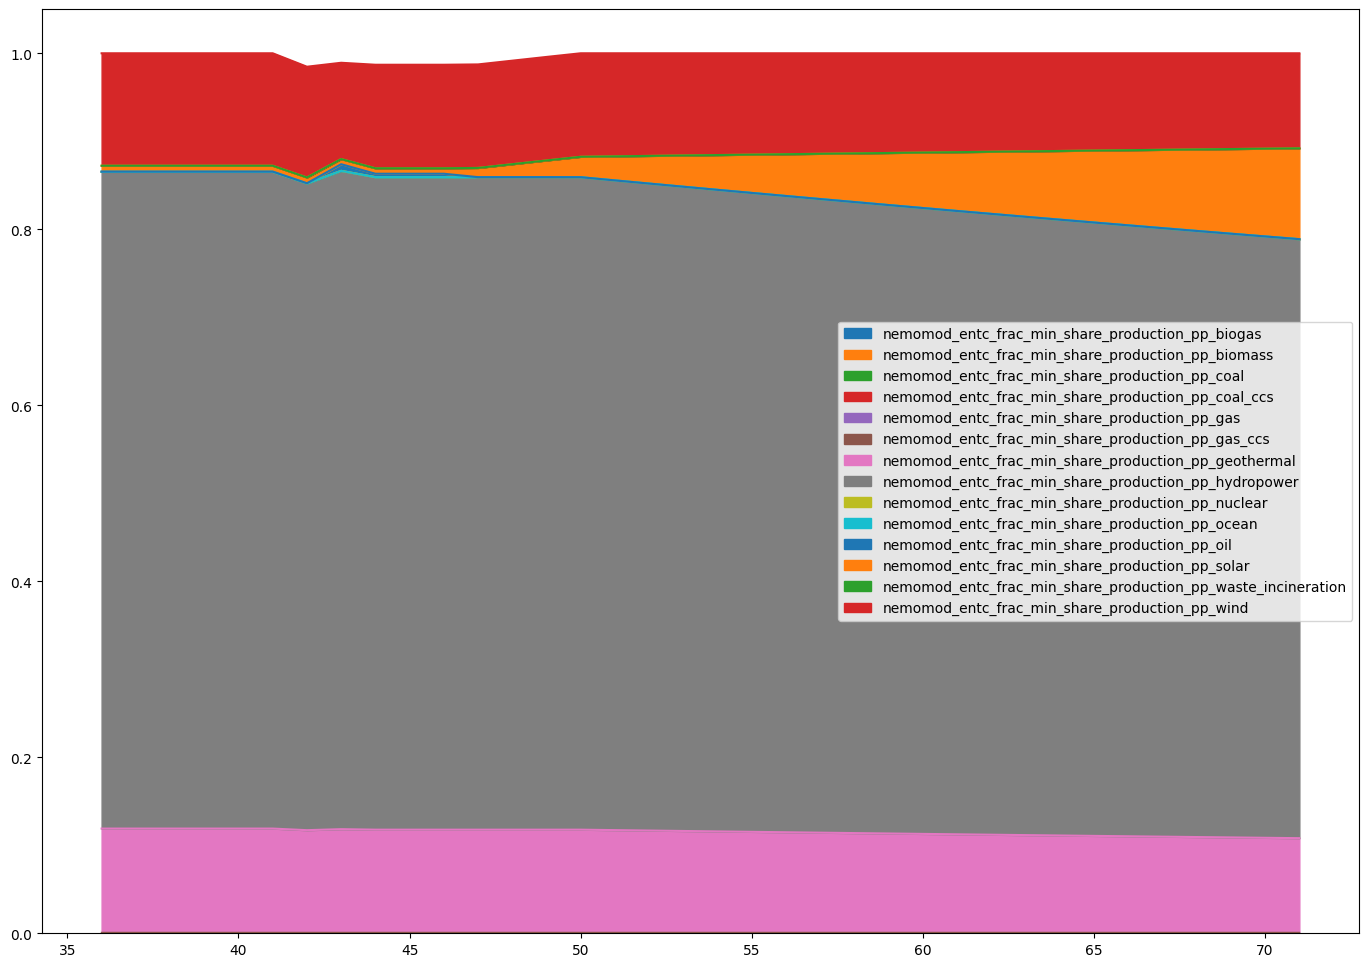

In [60]:
importlib.reload(tbe)
importlib.reload(dte)



# test the dict
dict_inputs = {}
for k, v in dict_config_te.items():
    dict_inputs.update({k: v})
dict_new = {"pp_solar": 0.15, "pp_geothermal": 0.1, "pp_wind": 0.15}
dict_inputs["dict_entc_renewable_target_msp"].update(dict_new)



region = "mexico"
te = dte.TransformationsEnergy(
    sa.model_attributes,
    dict_config_te,
    sa.dir_jl,
    sa.dir_ref_nemo,
    df_input[df_input[field_region].isin([region])],
    field_region = field_region,
)

df_in = df_input[df_input[field_region].isin(["mexico", "argentina", "honduras"])].reset_index(drop = True)
df_test = te.transformation_en_baseline(df_in)#, scale_non_renewables_to_match_surplus_msp = False)


fields_msp = [x for x in df_test.columns if ("min_share" in x) and ("hydrogen" not in x)]

fig, ax = plt.subplots(figsize = (17, 12))
df_test[df_test[field_region].isin(["honduras"])][fields_msp].plot.area(ax = ax)
#te.transformation_entc_renewables_target()/

<AxesSubplot: >

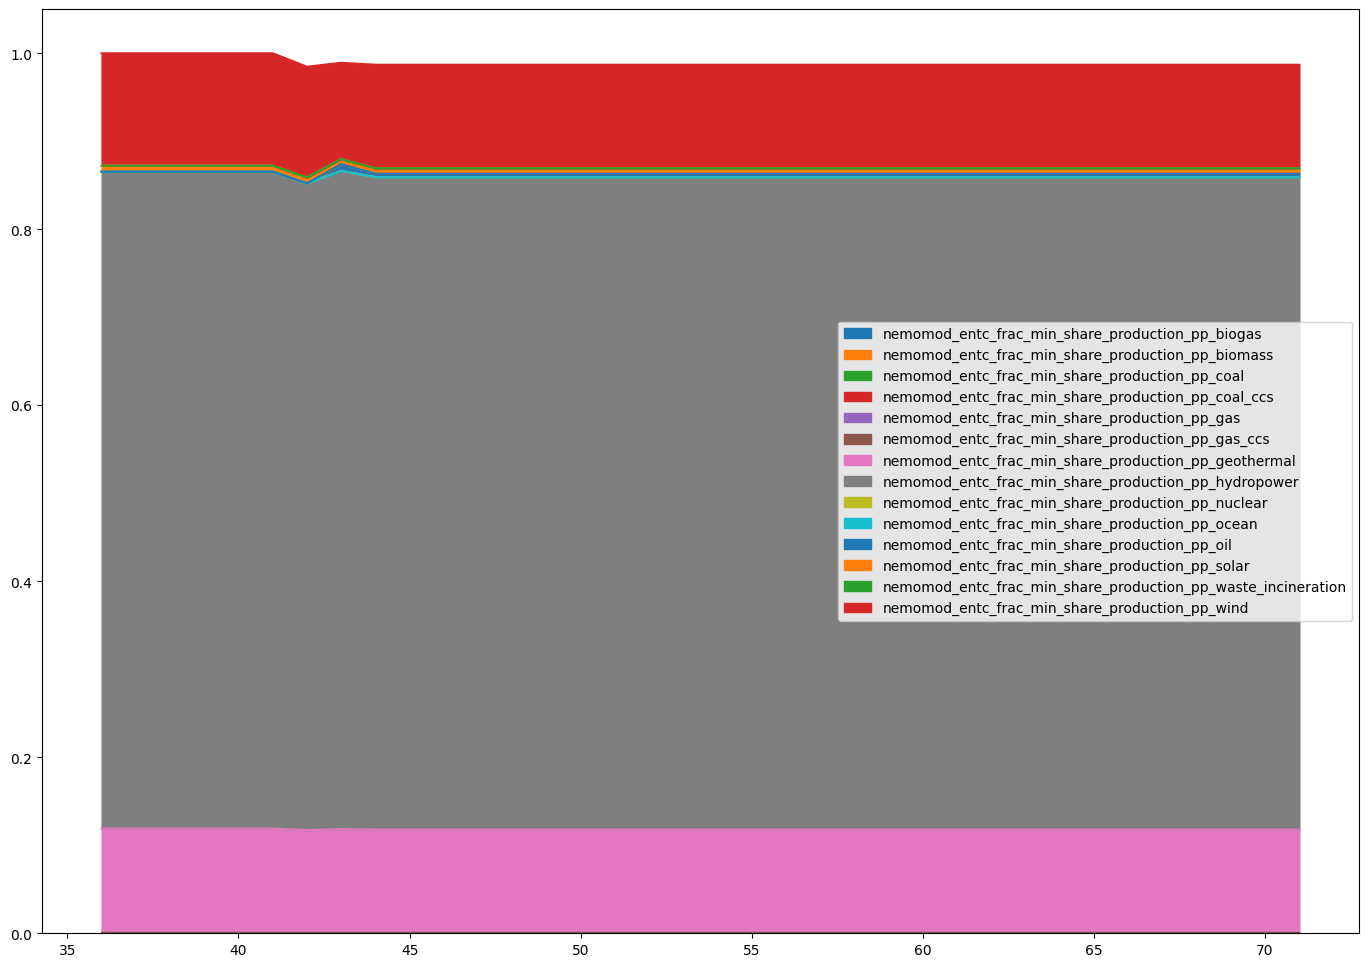

In [62]:
fig, ax = plt.subplots(figsize = (17, 12))
df_in[df_in[field_region].isin(["honduras"])][fields_msp].plot.area(ax = ax)

<AxesSubplot: >

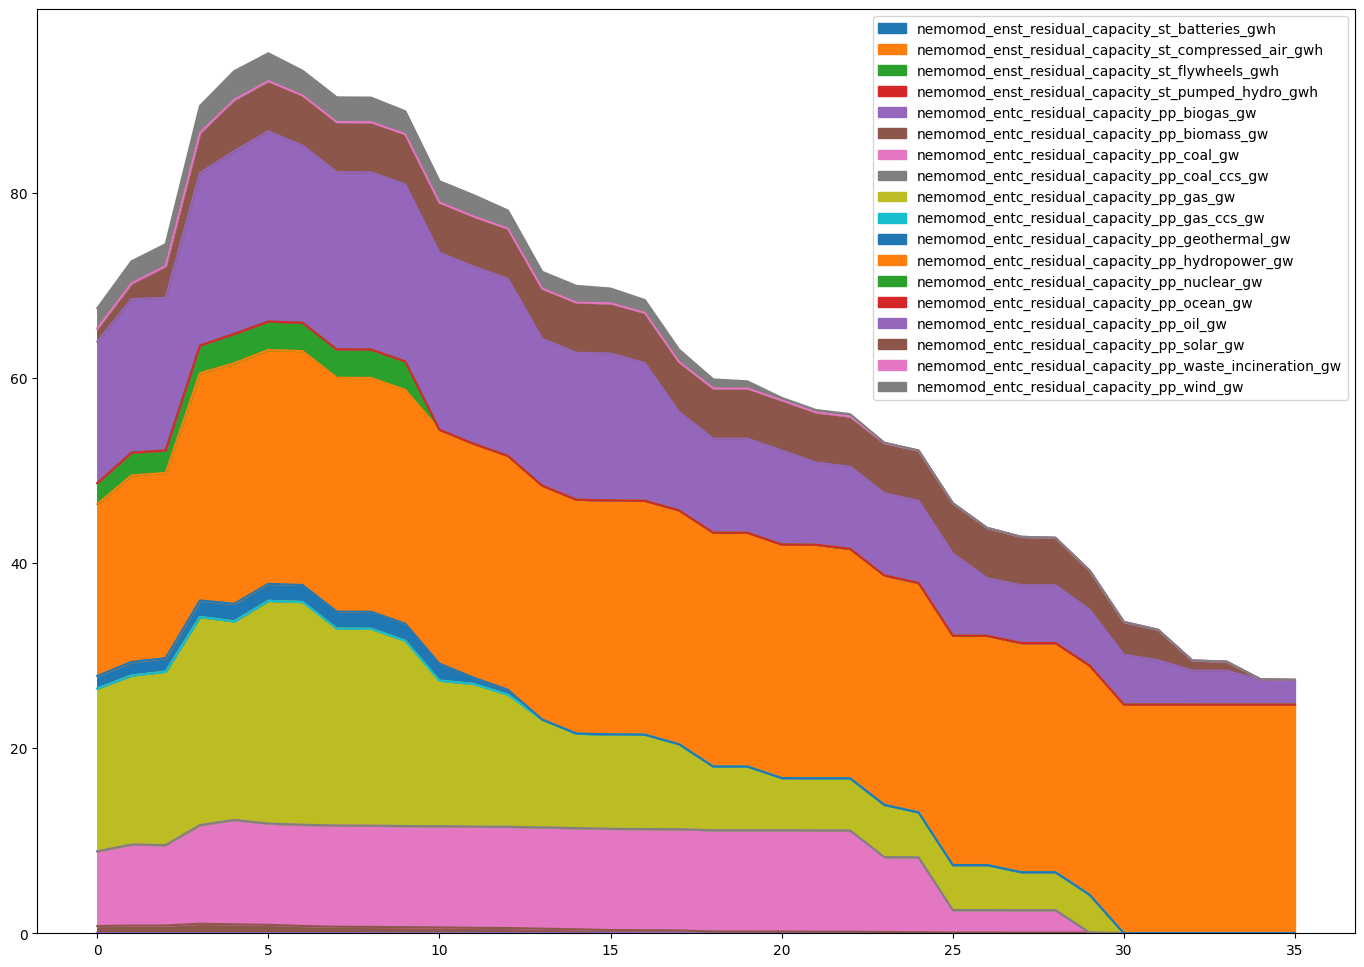

In [213]:
fields_rc = [x for x in df_test.columns if ("residual_capacity" in x)]

fig, ax = plt.subplots(figsize = (17, 12))
df_test[fields_rc].plot.area(ax = ax)
#te.transformation_entc_renewables_target()

# Run experiment (October 7 2023)
- response to reviewers
- Edmundo identified 5 primary ids from this set: `sisepuede_run_2023-10-06T20:10:09.932282`
- read these in, generate inputs, and map to templates


In [49]:
# read in data frame
fp_primaries_to_strategies = "/Users/jsyme/Documents/Projects/FY21/SWCHE131_1000/experiments_and_analysis/sisepuede_run_2023-10-06T20;10;09.932282/primary_ids_from_experiment_as_strategies;selection_for_uncertainty.csv"
df_primaries_to_strategies = pd.read_csv(fp_primaries_to_strategies)


# next, map primaries to new stratgy ids
primaries = sorted(list(df_primaries_to_strategies[sisepuede.key_primary]))
dict_primaries_to_strategies = dict((x, 5011 + i) for i, x in enumerate(primaries))



lhs_l, lhs_x, base_future_q = get_lhs_trajes(dict_filt)


df_in_base = ftc.generate_future_from_lhs_vector(
    None, 
    df_row_lhc_sample_l = 1.0, 
    future_id = 0, 
    baseline_future_q = True
)



{514914: 5011, 514926: 5012, 514978: 5013, 515112: 5014, 515483: 5015}